In the winter of 2023, Jordan Tigani declared that [big data is dead](https://motherduck.com/blog/big-data-is-dead/). In this blog post, he makes several claims about how much data that businesses typically query. It is easy to interpret this to mean that big data was just a hype and most of us shouldn't need to concern ourselves with it. I don't think that's the intended interpretation and I think that would be a mistake. The big data hype has lead to a lot of exciting innovations that increases the capability of commodity machines. I think it's unwise to ignore that, although I completely agree that most organizations do not need to set up multi-petabyte data platforms.

I can now easily run analytical queries on my laptop that people might've offloaded to clusters 5 or 10 years ago. Innovations in storage formats makes it possible for me to put quite large data sets on my laptop without having to delete everything else on the disk. NVMe disks are bonkers fast and make it much less punishing to work with data sets that do not fit in RAM. Our analytical tools can use HTTP range requests to only touch the required parts of data sets stored in cheap object storage and retrieve them with blazing speed if the bandwidth is good. Initiatives like [Apache Arrow](https://arrow.apache.org/) makes it cheap to transfer data between different analytics or storage engines on a single machine.

Many more data sets are now easily approachable with a normal laptop than 5 or 10 years ago. I want to write about and demo a technology I've been following for some years now. [DuckDB](https://duckdb.org/) is an in-process database, like sqlite, but tuned for analytical queries, rather than transactional queries. It has bindings for many languages, like Python, Java, Node, Rust and Wasm. It also has its own storage format, which is portable and backwards compatible on a timescale of some years into the future. So just like with sqlite, you can ship the database file to share your analysis with anyone else.

For me, I want to check if I can let DuckDB take over for spark/pyspark. Like spark, it can run queries on data that is much bigger than RAM. Unlike spark, it's not a cluster solution, so there should be much less overhead. It seems easy to read data from cheap object storage like S3, RDBMs systems or common storage formats with it, and it's very, very fast. I'm running this on a MacBook Pro M1 Max with 32GB RAM. It would cost me quite a bit of money to run a machine like that in the cloud, so I should try to make the best use of the one I have here right on my desk.

Today I'm going to do some hobby-analysis of public transportation delays in Trøndelag County to try to get a little familiar with DuckDB. I will be using the [Entur Real-Time](https://data.entur.no/domain/public-transport-data/product/realtime_siri_et/urn:li:container:1d391ef93913233c516cbadfb190dc65) data set of Norwegian public transport. This is a BigQuery table currently containing 2 246 751 479 records of 25 columns, and it claims to be about 500GB. This is definitely within the realm of what I would have considered Big Data not _that_ many years ago. With modern tools, I think it's more in the realm of "inconveniently sized" than truly "big".

It's possible to download slices of this data set from a [CSV exporter](https://siri-data-exporter.entur.no/), but the CSV files will be very big, and they'll also be [CSV](https://kaveland.no/posts/2024-03-10-friends-dont-let-friends-export-csv/). I will read the data from the BigQuery table instead. I'm primarily interested in transports in Trøndelag, so I will be filtering the data in my initial import, so we'll end up with a significantly smaller subset of this data locally. I will make sure to include the trains though, because I rely on them a lot! I get a lot of programming done on the train to/from Oslo.

## Setup

I've done some setup to prepare:

1. I made a Google Cloud account. Over at the [google cloud console](https://console.cloud.google.com/) I created a new project. I needed to enable billing to use BigQuery, but this data set is so small that it copying it probably won't incur any actual billing (this tells me that I'm probably not the target audience for BQ).
2. I enabled BigQuery API under APIs & Service somewhere.
3. Under IAM & Admin, I clicked Service Accounts and created one. I gave it the BigQuery User role.
4. On the service account details, I went to Keys and created a new key. This gave me a JSON file that I placed in `~/.bq_credentials`. When I want to authenticate to BigQuery, I make sure I have an environment variable named `GOOGLE_APPLICATION_CREDENTIALS` that points to that file, and the BQ sdk will pick it up.
5. I made the repository that this notebook is in and set it up with `uv init --name bus-eta --no-package --vcs git -p 3.12`.
6. I added the packages I'd like to use with `uv add duckdb pandas google-cloud-bigquery-storage google-cloud-bigquery pyarrow tqdm seaborn jupyter jupysql db-dtypes`. Note that `google-cloud-bigquery-storage` enables more efficient data transfer, using `arrow` or `avro` formats (we'll get arrow since we installed `pyarrow` but no `pyavro` package).
7. I added `*.db`, `*.wal`, `*.tmp`, `*.pq`, `*.parquet` to `.gitignore` so I wouldn't accidentally commit a huge data file.
8. If you want to play along, you can clone this repository, export a `GOOGLE_APPLICATION_CREDENTIALS` variable, run `uv sync` and `uv run jupyter lab` to get an interactive copy of this notebook to play around in. You can get uv from [here](https://docs.astral.sh/uv/). VSCode and JetBrains have plugins for working with jupyter notebook that are a lot better than running it in the browser, but the browser will work just fine too.

I haven't used DuckDB much before, I'm doing this to learn! I'm familiar with SQL, and DuckDB is based on the postgres dialect, so I should be fine. I'll be doing visualizations using [seaborn](https://seaborn.pydata.org/) which has a really nice API for quickly making beautiful plots of tabular data. This whole post is going to be a recording of my thoughts as I try to get familiar with both DuckDB and the Entur real time dataset. Hopefully I'll conclude that I can build something cool with it!

The data is available under the [NLOD](https://data.norge.no/nlod/no/1.0) data sharing license, if you want to use it, or the data I derive from it, you should check out the terms.

## Connecting to Big Query

Now let's get ready to fetch some data! Let's set up the BigQuery client and verify that we can access the table first:

In [1]:
import math
from datetime import timedelta

import numpy as np
import duckdb
import psutil
from tqdm.notebook import tqdm
from google.cloud import bigquery
import seaborn as sns
# Set up some styling for the visual stuff
sns.set_theme(
    style='whitegrid', rc={
        'figure.figsize': (12, 8),
        'figure.frameon': False,
        'legend.frameon': False
    }
)

source_table = "ent-data-sharing-ext-prd.realtime_siri_et.realtime_siri_et_last_recorded"
client = bigquery.Client()

client.query(
    f"select dataSource, dataSourceName, count(*) as volume from `{source_table}` where operatingDate > '2025-01-01' group by dataSource, dataSourceName"
).to_dataframe().sort_values(by='volume', ascending=False)

,dataSource,dataSourceName,volume
10,RUT,Ruter,20523199
9,SKY,Skyss,10799738
18,ATB,AtB,6512541
8,KOL,Kolumbus,6412608
16,VOT,Vestfold og Telemark fylkeskommune,5114716
3,AKT,AKT,4510360
0,INN,Innlandstrafikk,4194708
6,TRO,Troms fylkestrafikk,3512099
13,BRA,Brakar,3245036
5,MOR,FRAM,3104989


I'm not interested in all of these regional services, so I'll settle for the ones that I could conceivably encounter near Trondheim. That probably means these:

- `ATB` - the regional "brand" for Trøndelag
- `BNR` - BaneNOR, probably local and regional trains.
- `SJN` - SJ Nord operate Dovrebanen between Oslo and Trondheim, as well as Nordlandsbanen between Trondheim and Bodø.

Let's set up a connection to a DuckDB instance at `entur.db` first. This will create persistent storage on my disk, if it doesn't exist yet. The "connection" part is somewhat of a misnomer, since there's no server -- just like with sqlite, everything interesting is happening with files and memory here. I've decided to name the table for the raw data `arrivals`. Since I want to be able to rerun this notebook from top to bottom efficiently, I will only create it if it does not exist already.

## Creating a local DuckDB database file

From the [documentation](https://duckdb.org/docs/guides/performance/how_to_tune_workloads) I discovered that DuckDB can sometimes create too many threads. I'll manually set a thread count to the number of physical cores, leaving 1 for the rest of the system, to avoid overloading it.

In [2]:
db = duckdb.connect("entur.db")
cores = psutil.cpu_count(logical=False) - 1
db.execute(f"set threads = {cores};")
exists = db.sql("select exists(select 1 from information_schema.tables where table_name = 'arrivals')").fetchone()[0]

The DuckDB API generally does a good job of mimicking existing database APIs in the various languages. The `fetchone()`-method is part of the [DB-API](https://peps.python.org/pep-0249/) spec.

Next up, we'll write the query for the data set we want from Big Query. If I was planning on doing anything serious, I would probably find a better way of constructing the query strings, I'm certain BQ supports bind parameters. I'm not supplying any user input though, so I won't need it, and BQ isn't the topic of this post.

In [3]:
query = f"""
SELECT
  recordedAtTime,
  lineRef,
  directionRef,
  operatingDate,
  vehicleMode,
  extraJourney,
  journeyCancellation,
  stopPointRef,
  sequenceNr,
  stopPointName,
  originName,
  destinationName,
  extraCall,
  stopCancellation,
  estimated,
  aimedArrivalTime,
  arrivalTime,
  aimedDepartureTime,
  departureTime,
  datedServiceJourneyId
FROM `{source_table}`
WHERE dataSource in ('ATB', 'BNR', 'SJN', 'FLT') -- NB! This selects trains and Trøndelag. Maybe you want something else?
"""

I'm not interested in running this query more than once. It's going to transfer a lot of data over the wire, hopefully in an efficient binary format like Avro or Parquet, but it's still going to take a while. In case the data is too big for RAM, I will naively paginate it by grabbing 14 days worth of data at a time. The BQ sdk probably has a nicer way of doing this, but it's yet again not the topic of this post. This is probably going to take a while, so it's time to get a coffee...

**Edit: Important note**: If you're running this notebook, you may want to adjust the `start`-variable to avoid pulling down all the data since the beginning of time. It'll be much faster, and many things have changed in traffic the past 5 or so years anyway. Near the end of this notebook you'll notice that I throw out all data before 2024-01-01 anyway.

In [4]:
if not exists:
    # download it, paged 1 month per page
    rs = client.query(f"""
    SELECT MIN(operatingDate) as min_record,
           MAX(operatingDate) as max_record
    FROM `{source_table}`
    WHERE dataSource in ('ATB', 'BNR', 'SJN', 'FLT') -- NB! This selects trains and Trøndelag. Maybe you want something else?
    """).result()
    row = list(rs)[0]

    start, end = row.get("min_record"), row.get("max_record")
    page_delta = timedelta(days=30)
    page_count = math.ceil(((end - start) / page_delta))
    page_boundaries = [
        start + n * page_delta
        for n in range(page_count + 1) # include last page
    ]
    created = False
    for start, end in tqdm(list(zip(page_boundaries, page_boundaries[1:]))):
        job = client.query(f"{query} AND operatingDate >= '{start.isoformat()}' AND operatingDate < '{end.isoformat()}'")
        batch = job.to_arrow()
        if created:
            db.execute("insert into arrivals select * from batch")
        else:
            db.execute("create table arrivals as select * from batch")
            created = True

db.query("select count(*) as rows_found from arrivals")

  0%|          | 0/62 [00:00<?, ?it/s]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┐
│ rows_found │
│   int64    │
├────────────┤
│  214536918 │
└────────────┘

The code above may look strange for a few reasons. There's the string-interpolation query which I apologize for. And then there's this section:
```python
        batch = job.to_arrow()
        if created:
            db.execute("insert into arrivals select * from batch")
        else:
            db.execute("create table arrivals as select * from batch")
```

First, we grab the result set from BigQuery as an arrow table. This is a memory layout and wire format for tabular data defined by the [Apache Arrow](https://arrow.apache.org/) project. DuckDB understands this format natively. BigQuery can use the wire format. There's no `batch` table in `entur.db`, what's happening there is that we're using something called a [replacement scan](https://duckdb.org/docs/clients/c/replacement_scans.html). Since DuckDB is in our process memory, it can access `batch` on the C level and query _directly_ against it, no copying necessary. polars can also understand this memory layout, as can pandas, and many other in-process analytical engines, like R for example.

This took a surprisingly long time to run the first time around, around 20 minutes on my 750/750 Mbps line. Since we're selecting only around 1/25th of the data, we could extrapolate that we'd need 8 hours or so to download the whole thing. This may seem like a lot, but considering how "little" extra data is added over time here, an initial slow sync, followed by a daily update to keep the laptop in sync would be totally fine. I'm pretty confident my laptop could handle analytical queries on that amount of data just fine.

## Configuring `jupysql` with DuckDB

In case you haven't noticed yet, this blog is actually a Jupyter Notebook. That enables us to promote DuckDB into a first class citizen by enabling `jupysql`, so let's do that:


In [5]:
%load_ext sql
%sql db --alias duckdb
%config SqlMagic.displaylimit = 50

The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Now we can very easily mix and match Python for visualization and SQL for analysis. Let's give it a go:

Running query in 'duckdb'

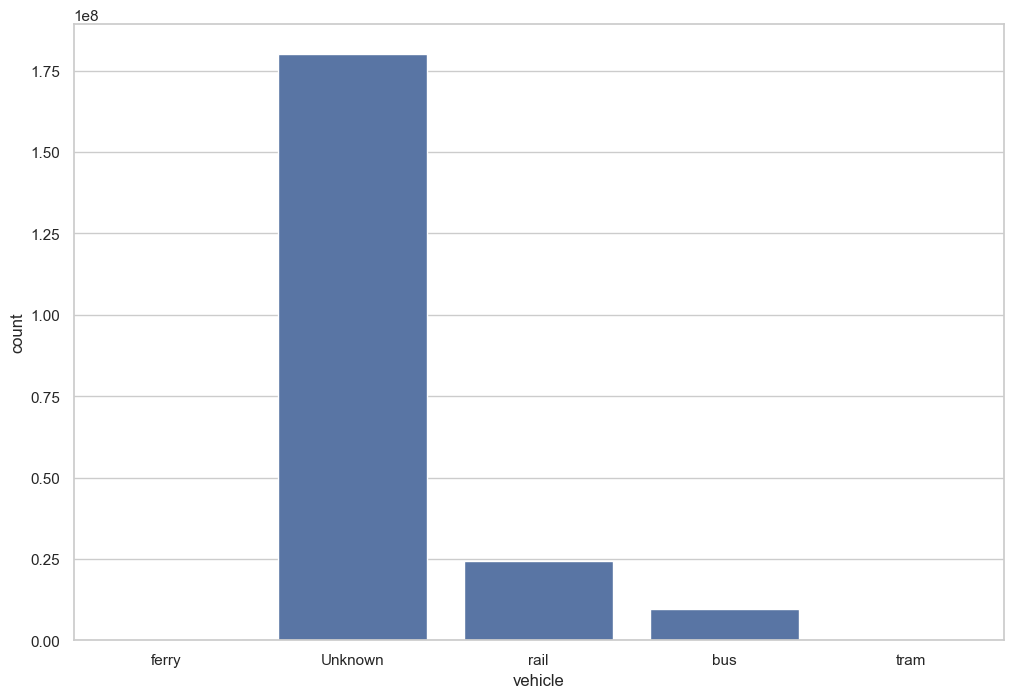

In [6]:
rs = %sql SELECT COALESCE(vehicleMode, 'Unknown') as vehicle, COUNT(*) as count FROM ARRIVALS GROUP BY vehicleMode
sns.barplot(rs.DataFrame(), x='vehicle', y='count');

Right, we've got it working. I will prefer to use the `%%sql` syntax that turns a whole cell/codeblock into sql, instead of the `%sql` which only does it on the rest of the line. It's going to make syntax highlighting work out better.

It seems like perhaps `vehicleMode` is a relatively new field, or maybe not exposed by all the transport vendors. We did store all the data to `entur.db`. There are some 200 million rows in there. Let's check how big it is:

In [7]:
!du -hs entur.db

9.2G	entur.db


Just for fun, let's find out what size it would be in CSV (then immediately delete it):

In [8]:
%time db.execute("COPY arrivals TO 'arrivals.csv' (HEADER, DELIMITER ';')")
!du -hs arrivals.csv
!time wc -l arrivals.csv
!rm arrivals.csv

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 5min 17s, sys: 32.7 s, total: 5min 49s
Wall time: 42.3 s
 56G	arrivals.csv
 214536919 arrivals.csv
wc -l arrivals.csv  56.77s user 6.79s system 97% cpu 1:04.91 total


Quick summary of that, the `entur.db` DuckDB file is roughly 6 times smaller than the 56GB CSV file, which we wasted 40+ seconds writing. It took `wc` even longer than that to scan through the file. I'd be willing to bet real money that DuckDB can do an aggregation across this table in less than a second on my machine.

Let's check the busiest stations. We will use the DuckDB relations API and replacement scans to make this convenient, so we can break it up into multiple queries.

In [9]:
%%time
by_station_name = db.sql("select stopPointName, count(*) as count from arrivals group by stopPointName")
top_10 = db.sql("select stopPointName, count from by_station_name order by count desc limit 10")
top_10.df()

CPU times: user 976 ms, sys: 168 ms, total: 1.14 s
Wall time: 144 ms


,stopPointName,count
0,Nidarosdomen,2816908
1,Hesthagen,1752426
2,Valøyvegen,1391607
3,Rønningsbakken,1354974
4,Studentersamfundet,1336844
5,Bratsbergvegen,1312606
6,Bakkegata,1274292
7,Oslo S,1254969
8,Solsiden,1206107
9,Strindheim,1190255


That was 117ms the first time I ran it, and I didn't have to do anything clever.

Let's check how a `.parquet` file would come out, that too would probably give us a compact file that we could query efficiently:

In [10]:
%time db.execute("COPY arrivals TO 'arrivals.parquet'")
!du -hs arrivals.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 2min 19s, sys: 4min 29s, total: 6min 49s
Wall time: 58.1 s
7.8G	arrivals.parquet


This has even better compression, and DuckDB can easily query this too:

In [11]:
%%time
by_station_name = db.sql("select stopPointName, count(*) as count from 'arrivals.parquet' group by stopPointName")
top_10 = db.sql("select stopPointName, count from by_station_name order by count desc limit 10")
top_10.df()

CPU times: user 11.8 s, sys: 421 ms, total: 12.2 s
Wall time: 1.52 s


,stopPointName,count
0,Nidarosdomen,2816908
1,Hesthagen,1752426
2,Valøyvegen,1391607
3,Rønningsbakken,1354974
4,Studentersamfundet,1336844
5,Bratsbergvegen,1312606
6,Bakkegata,1274292
7,Oslo S,1254969
8,Solsiden,1206107
9,Strindheim,1190255


That's a bit longer at 1.6s on first recording, but still quick. Compact binary formats are *nice*, we can do very fast aggregations. Both the DuckDB format and `.parquet` files contain schemas, and enough information so that the majority of the file can be skipped. They're also much more compact, so reading into memory from them is also fast. I feel like it's time to start figuring out what the data actually looks like.

## Exploring the data

As far as I can tell, each row is a record of a transport service at a physical location and time, together with information about the planned, estimated and actual schedule. Let's look at one whole example. I have picked a bus stop where I frequently take the bus, and hardcoded `datedServiceJourneyId` for one particular journey. I don't want this notebook to accidentally change if I load more data at some later point. I know this as the "14 bus".

In [12]:
journey = "2024-02-10:ATB:ServiceJourney:14_230306097868553_6050"

db.sql("""
select * from arrivals
where datedServiceJourneyId = ? and stopPointName = 'Åsvang skole'
limit 1
""", params=[journey]).df().T

,0
recordedAtTime,2024-02-10 15:53:30.179714+01:00
lineRef,ATB:Line:2_14
directionRef,Inbound
operatingDate,2024-02-10 00:00:00
vehicleMode,None
extraJourney,False
journeyCancellation,False
stopPointRef,NSR:Quay:72787
sequenceNr,9
stopPointName,Åsvang skole


Okay, so this the bus service I use for work, it's the only bus to visit this stop point. That helps me get my bearings.

There's a `stopPointRef`, which is probably the ID of the stop point. It's probably a reference to the ID in [this dataset](https://data.entur.no/domain/public-transport-data/product/national_stop_registry/urn:li:container:7fd60886cfa95c660d5c85ac0384eb9a)?

`lineRef` looks like some sort of composite hierarchical ID. The bus has ATB-branding, and the number 14. The 2 is probably a code or ID for something. Maybe we'll figure that out later.

There's no `vehicleMode`, but I know that this is a bus. I could probably backfill this column by identifying that this stop point is for buses if I wanted to, but I don't think I need this column for my analysis.

I'm not sure what I would want to do with the `extraJourney` column. This seems likely to be train-related, according to the documentation a true value here means the vehicle journey is a replacement journey (probably like bus for train or bus for ferry). For now, I'll disregard it. If there's a `journeyCancellation`, I think it's likely that we'll see a value for `arrivalTime` or `departureTime`, so I guess we don't need that either.

`extraCall` means that the stop at this place was in addition to the scheduled stops. I don't think I need to worry about this. `stopCancellation` means that the service skipped a stop that was planned. I also don't think I need this, nor `estimated`, as I only care about scheduled and actual times.

As far as I can tell, `datedServiceJourneyId` can be used to find all the registrations for one journey, and they should be ordered by their `SequencNr`. Let's check that:

In [13]:
%%sql
SELECT
  stopPointName,
  aimedArrivalTime,
  arrivalTime,
  aimedDepartureTime,
  departureTime
FROM
  arrivals
  -- apparently %%sql uses jinja templates
WHERE
  arrivals.datedServiceJourneyId = '{{ journey }}'
ORDER BY
  sequenceNr asc;

Running query in 'duckdb'

stopPointName,aimedArrivalTime,arrivalTime,aimedDepartureTime,departureTime
Bratsbergvegen,None,None,2024-02-10 15:18:00+01:00,2024-02-10 15:18:20+01:00
Valøyvegen,2024-02-10 15:19:00+01:00,2024-02-10 15:19:37+01:00,2024-02-10 15:19:00+01:00,2024-02-10 15:20:08+01:00
Lerkendal,2024-02-10 15:20:00+01:00,2024-02-10 15:21:20+01:00,2024-02-10 15:20:00+01:00,2024-02-10 15:21:58+01:00
Lerkendal gård,2024-02-10 15:21:00+01:00,2024-02-10 15:22:26+01:00,2024-02-10 15:21:00+01:00,2024-02-10 15:22:36+01:00
Berg studentby,2024-02-10 15:22:00+01:00,2024-02-10 15:23:29+01:00,2024-02-10 15:22:00+01:00,2024-02-10 15:24:05+01:00
Østre Berg,2024-02-10 15:24:00+01:00,2024-02-10 15:25:45+01:00,2024-02-10 15:24:00+01:00,2024-02-10 15:26:19+01:00
Moholt studentby,2024-02-10 15:25:00+01:00,2024-02-10 15:27:54+01:00,2024-02-10 15:25:00+01:00,2024-02-10 15:28:30+01:00
Voll studentby,2024-02-10 15:27:00+01:00,2024-02-10 15:29:58+01:00,2024-02-10 15:27:00+01:00,2024-02-10 15:30:34+01:00
Åsvang skole,2024-02-10 15:28:00+01:00,2024-02-10 15:31:39+01:00,2024-02-10 15:28:00+01:00,2024-02-10 15:32:10+01:00
Høyset,2024-02-10 15:29:00+01:00,2024-02-10 15:32:40+01:00,2024-02-10 15:29:00+01:00,2024-02-10 15:33:28+01:00


Okay, that looks like it's the correct interpretation, I take this bus quite often. This particular journey, the bus has been delayed according to the planned schedule. That's exactly the kind of thing I'm interested in looking for. I can easily check _how_ delayed it is at any given stop by matching the `aimedArrivalTime` to the `arrivalTime`. This would let me answer questions like what time of the day that frequent delays at any given stop.

Let's pick the highest volume stop and check the mean delay of each bus that visits it, by hour of day, month, and by year.

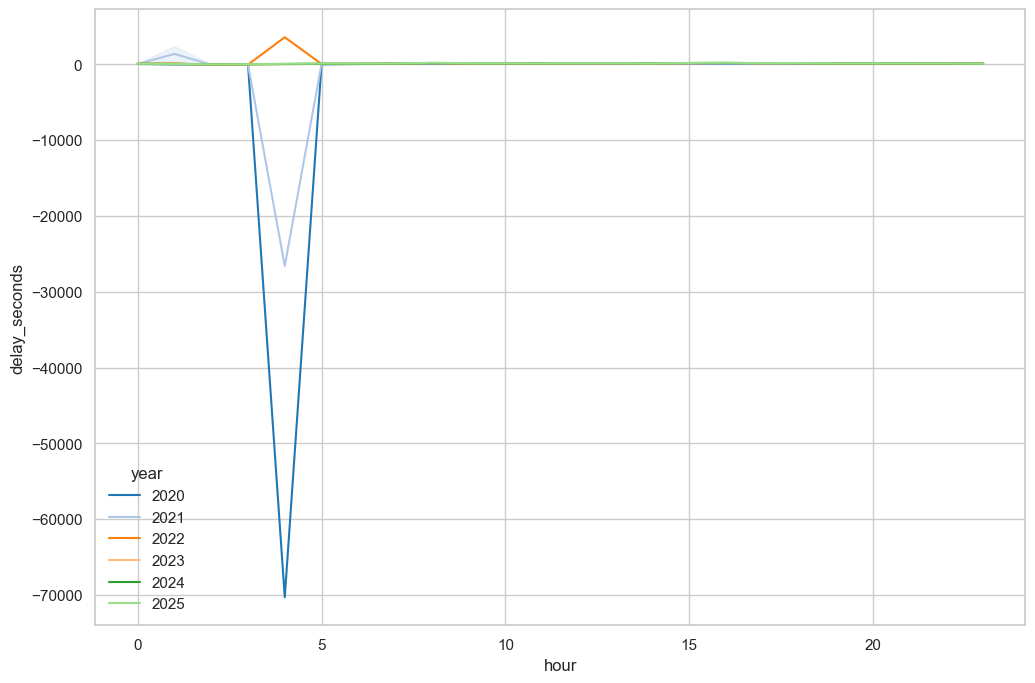

In [14]:
df = db.sql("""
select
  mean(extract(epoch from arrivalTime - aimedArrivalTime)) as delay_seconds,
  extract(year from arrivalTime) :: text as year,
  extract(hour from arrivalTime) as hour,
  extract(month from arrivalTime) as month
from arrivals
where stopPointName = 'Nidarosdomen'
group by 2, 3, 4
""").df()

sns.lineplot(
    df, x='hour', hue='year', y='delay_seconds', palette='tab20'
);

From this we can conclude only that the data registration isn't perfect (this is usually what happens any time I try to analyze anything at all), or perhaps something dramatic has been going on in the real world. We'll look at a subset of the services with the biggest deviations to see if there's anything we can use to remove them.

In [15]:
%%sql
WITH
  deviations AS (
    SELECT
      lineRef,
      arrivalTime,
      aimedArrivalTime,
      EXTRACT(
        epoch
        FROM
          arrivalTime - aimedArrivalTime
      ) AS delay_seconds,
    FROM
      arrivals
    WHERE
      stopPointName = 'Nidarosdomen'
  )
SELECT
  *
FROM
  deviations
ORDER BY
  ABS(delay_seconds) desc
LIMIT
  30;

Running query in 'duckdb'

lineRef,arrivalTime,aimedArrivalTime,delay_seconds
ATB:Line:1600003,2020-03-20 04:40:20+01:00,2020-03-21 00:12:00+01:00,-70300.0
ATB:Line:1600001,2020-03-20 05:01:17+01:00,2020-03-20 23:42:00+01:00,-67243.0
ATB:Line:1600003,2022-10-17 08:50:09+02:00,2022-10-18 00:30:00+02:00,-56391.0
ATB:Line:1600012,2020-04-30 19:18:45+02:00,2020-04-30 08:55:00+02:00,37425.0
ATB:Line:1600012,2020-05-02 19:14:08+02:00,2020-05-02 08:55:00+02:00,37148.0
ATB:Line:1600012,2020-04-30 17:18:37+02:00,2020-04-30 08:35:00+02:00,31417.0
ATB:Line:1600012,2020-05-02 17:15:10+02:00,2020-05-02 08:35:00+02:00,31210.0
ATB:Line:1600001,2022-01-17 05:01:46+01:00,2022-01-17 13:03:00+01:00,-28874.0
ATB:Line:1600012,2020-05-02 16:22:27+02:00,2020-05-02 08:25:00+02:00,28647.0
ATB:Line:2_3,2023-01-19 00:32:49+01:00,2023-01-18 16:49:00+01:00,27829.0


These don't appear to have anything in common, it might be hard to fix this problem. Perhaps what's happened is that the "journey" was reused, or there was a swap of which buses that would service which schedule. At first glance, this problem seems to have been bigger in the past than in the present. It's really not interesting to analyze these outliers, for now, we'll just filter out any delays longer than 30 minutes and try again.

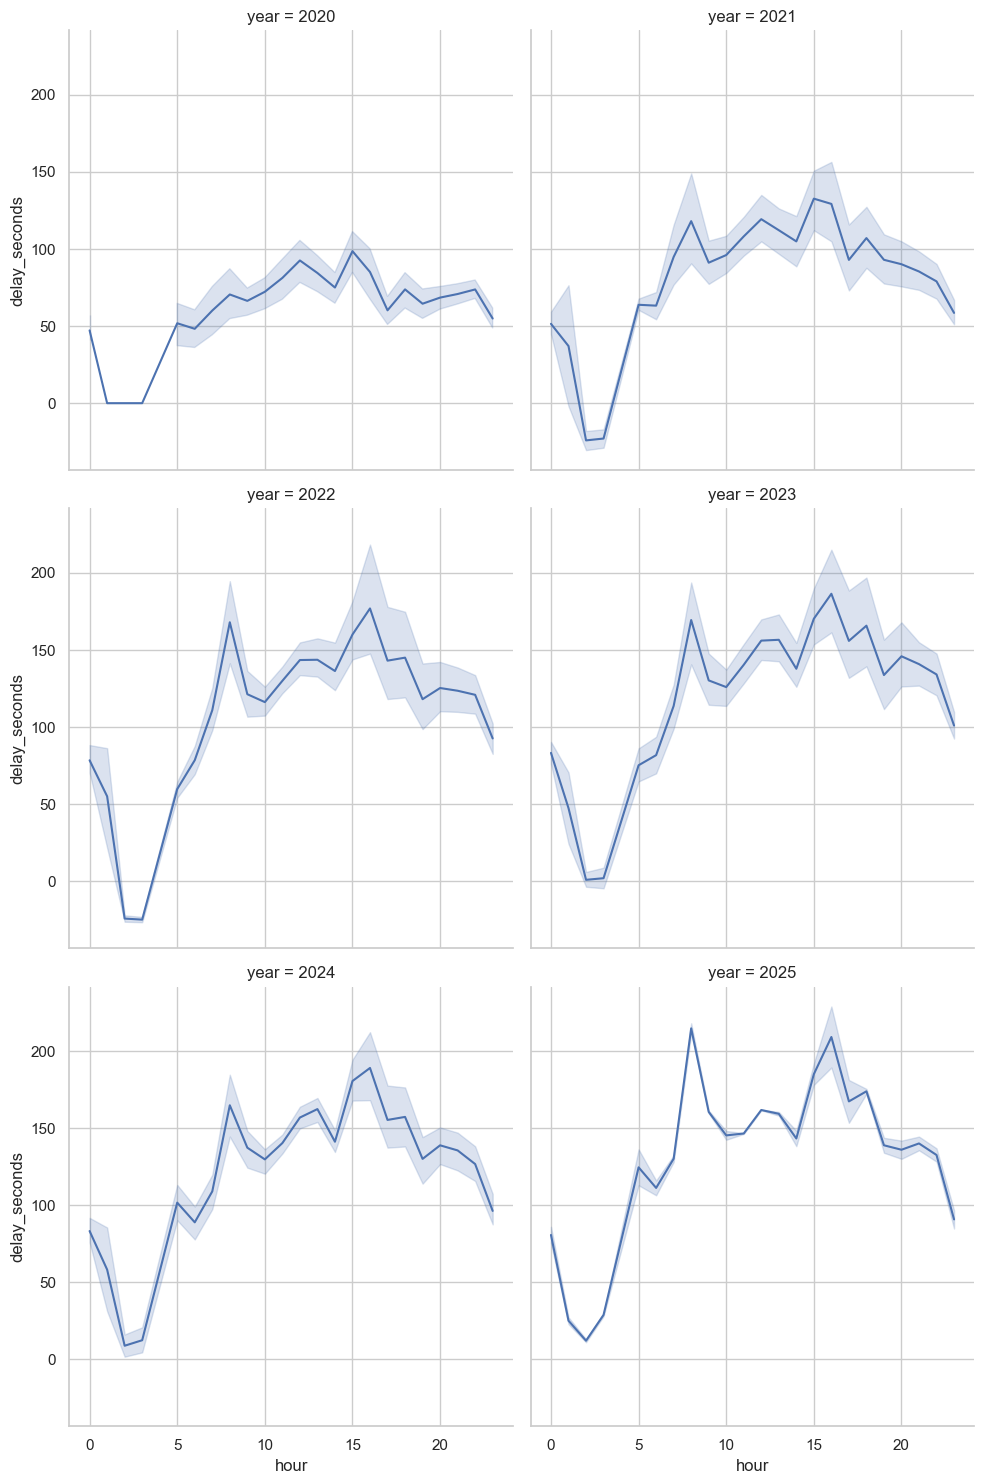

In [16]:
df = db.sql("""
select
  mean(extract(epoch from arrivalTime - aimedArrivalTime)) as delay_seconds,
  extract(year from arrivalTime) as year,
  extract(hour from arrivalTime) as hour,
  extract(month from arrivalTime) as month
from arrivals
where stopPointName = 'Nidarosdomen' and abs(extract(epoch from arrivalTime - aimedArrivalTime)) < 1800
group by 2, 3, 4
""").df()

sns.relplot(
    df, x='hour', col='year', col_wrap=2, y='delay_seconds', kind='line'
);

It is interesting for me to note that the schedules are optimistic on average. 0 delay does not seem to be in the 95% confidence interval of the shaded region at all. The effect of rush hour on the delay seems to have been increasing in recent years, but the variability is not huge. Let's check if some months are worse than others:

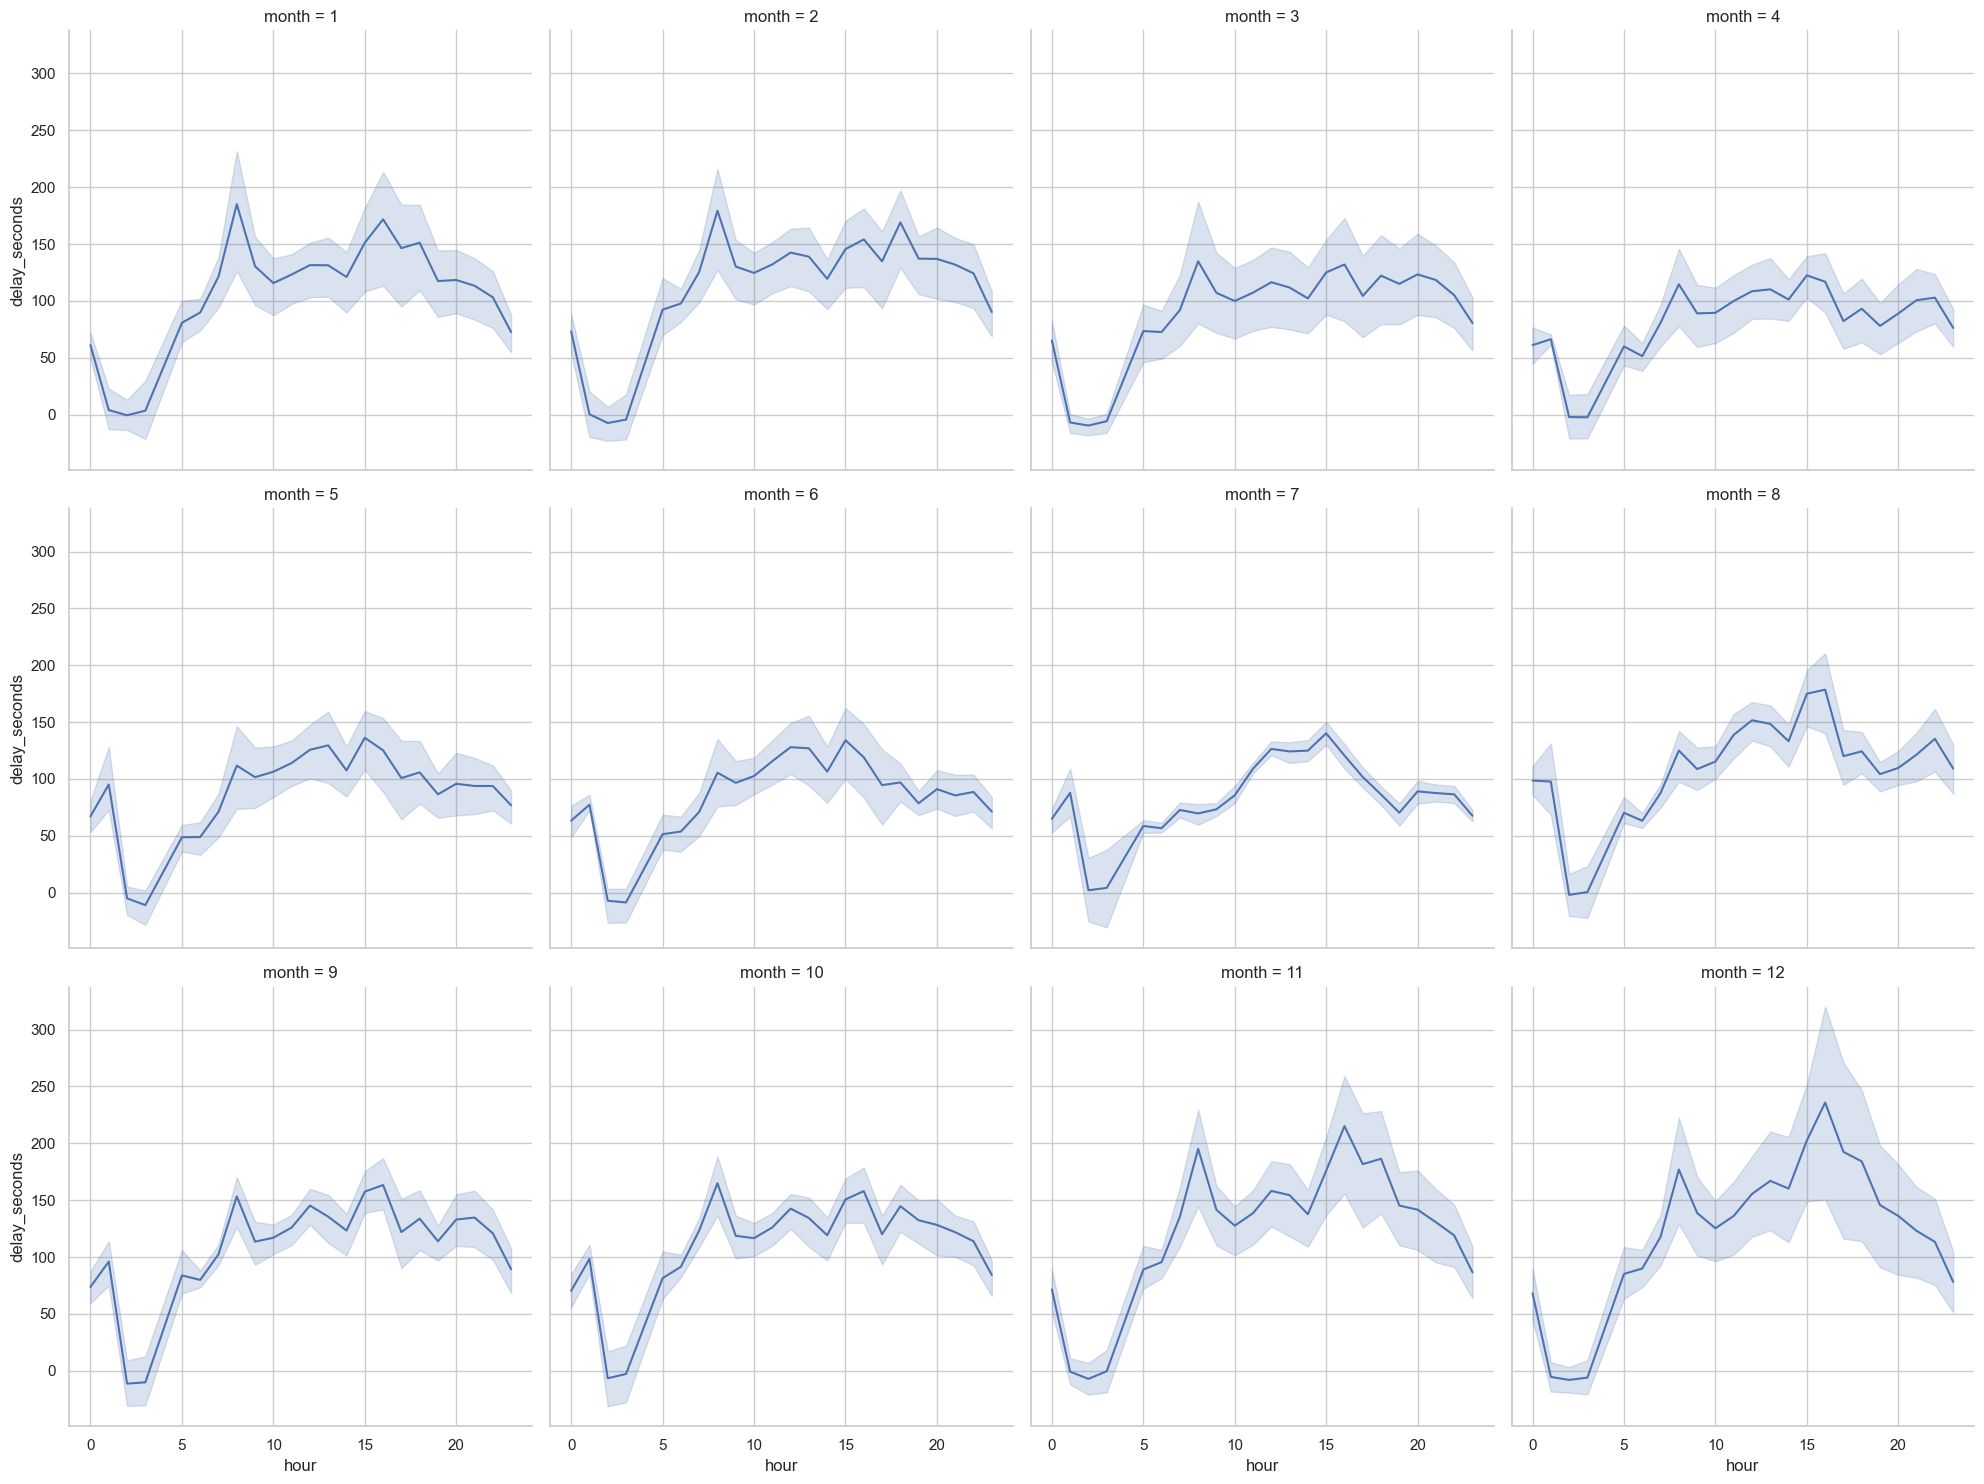

In [17]:
sns.relplot(
    df, x='hour', col='month', col_wrap=4, y='delay_seconds', kind='line'
);

Right, that's not a big surprise -- there's much greater variability in the months when we have snowfalls. This is very visible in December, where taking the bus after work has historically been a somewhat unpredictable and annoying ordeal for me. It might not necessarily be caused by snowfalls though. Fewer people use their bike when the cold sets in, and so road traffic may also increase.

## What we learned

It seems like we can use this data set to investigate bus delays, but there are some outliers. These don't tell us much about what's _typical_ or _likely_, so we'll remove them.

We should be on the lookout for optimistic schedules. We've only investigated one stop so far, but there was a significant skew to the optimistic side. It would be interesting to check if this is caused by a few bus lines always being late, or if it distributes more uniformly.

Rush hour has an impact that the schedules for lines passing Nidarosdomen that schedules do not fully account for. We can also see that buses are less reliable when winter starts and ends. It might be interesting to pull down some weather data from [frost](https://frost.met.no/index.html) to investigate that in the future.

## Next questions

1. Are some bus lines disproportionally represented in the delays?
2. _Where_ do the buses get delayed? Is it a slow accrual of time loss due to an optimistic schedule, or are there certain areas where traffic just doesn't flow at certain times?

Let's focus on question 1 first, question 2 seems like a good way to round off this little project with some sort of fun finding that we can show. First, let's figure out which lines that visit Nidarosdomen and their mean delay. That would probably be every line going through downtown on the North-South axis, so probably a lot:

In [18]:
%%sql
SELECT
  lineRef,
  COUNT(*) AS COUNT,
  mean (
    EXTRACT(
      epoch
      FROM
        arrivalTime - aimedArrivalTime
    )
  ) AS mean_delay_seconds
FROM
  arrivals
WHERE
  stopPointName = 'Nidarosdomen'
  AND ABS(
    EXTRACT(
      epoch
      FROM
        arrivalTime - aimedArrivalTime
    )
  ) < 1800
GROUP BY
  lineRef
ORDER BY
  COUNT(*) desc
LIMIT
  30

Running query in 'duckdb'

lineRef,COUNT,mean_delay_seconds
ATB:Line:1600001,182065,111.26719734402549
ATB:Line:1600003,167962,74.24555376383348
ATB:Line:1600002,167903,97.85721148212954
ATB:Line:2_1,162681,162.59204285499845
ATB:Line:2_3,149237,113.00966406925896
ATB:Line:2_2,149153,163.7758373889496
ATB:Line:1600012,147140,86.75142825478456
ATB:Line:1600025,138400,126.43963046916906
ATB:Line:2_12,127607,140.71654420309233
ATB:Line:1600011,119155,100.38976123542444


It is easy to see that not all lines contribute the same here without any further analysis. The mean spans from more than 4 minutes to 70 seconds, and all of these have many registrations.

Let's sample a couple of lines:

- `ATB:Line:2_1` which is probably the metro bus line 1.
- `ATB:Line:2_10` which might be bus line 10?
- `ATB:Line:2_71` which might be 71 to/from Melhus?

We'll try to find out if these lines have delay distributions that have the same shape.

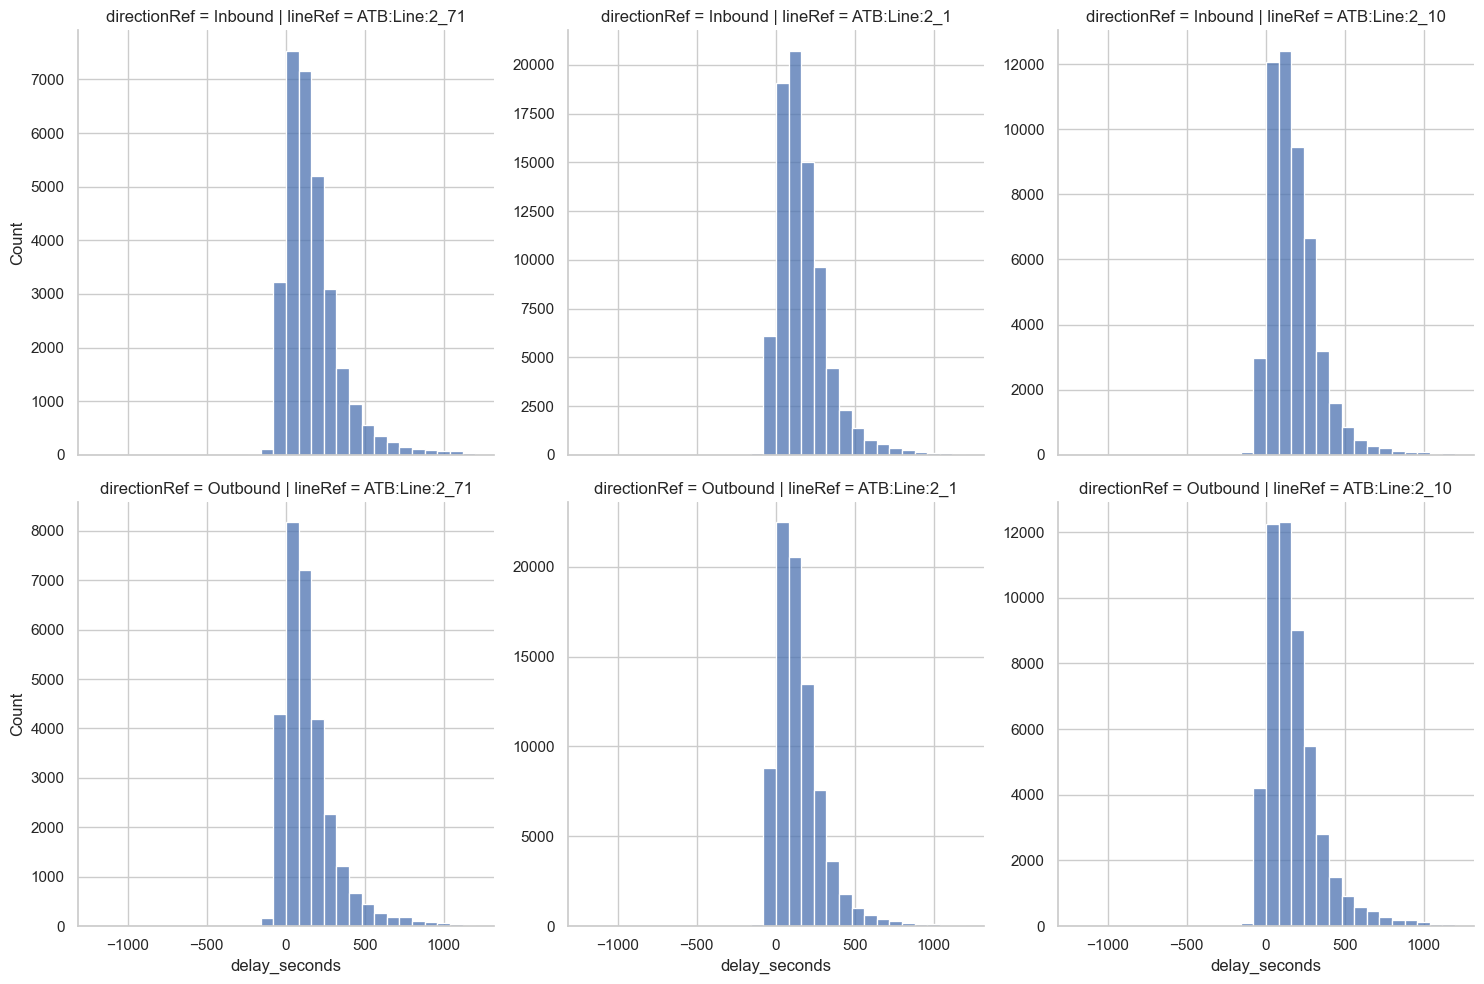

In [19]:
df = db.sql("""
select
  lineRef,
  extract(epoch from arrivalTime - aimedArrivalTime) as delay_seconds,
  directionRef
from arrivals
where stopPointName = 'Nidarosdomen'
  and abs(extract(epoch from arrivalTime - aimedArrivalTime)) < 1200
  and lineRef in ('ATB:Line:2_1', 'ATB:Line:2_10', 'ATB:Line:2_71')
""").df()

sns.displot(
    df, x='delay_seconds', row='directionRef', col='lineRef', kind='hist', facet_kws={'sharey': False}, bins=30
);

The shape of all these look quite similar. Let's pick a single bus line and plot the delay by the sequenceNr to find out if it's just accruing delay gradually, or whether there's some physical place where the magic happens. This is going to be pretty slow, because we're asking seaborn to calculate confidence intervals for some pretty big data sets -- it's the visualization that takes time, not the query.

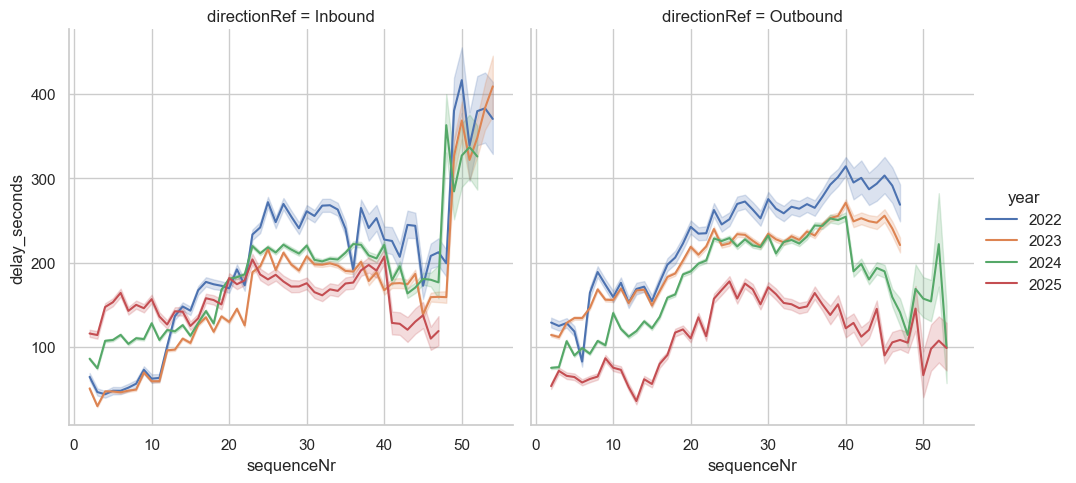

In [20]:
df = db.sql("""
select
  lineRef,
  extract(epoch from arrivalTime - aimedArrivalTime) as delay_seconds,
  directionRef,
  sequenceNr,
  extract(year from arrivalTime) as year
from arrivals
where abs(extract(epoch from arrivalTime - aimedArrivalTime)) < 1800
  and lineRef = 'ATB:Line:2_10'
""").df()

sns.relplot(
    # This cast is a little dirty, it's just the quickest way to force seaborn
    # to create a legend for a categorical variable instead of a continuous one.
    # It'll make sure that each year gets a nice and distinct color.
    df.astype({'year': 'string'}),
    x='sequenceNr', y='delay_seconds', col='directionRef', kind='line', hue='year'
);

Wow, the error bars for these are super low, the 95% confidence interval is barely visible. I was not expecting that, it makes me believe I've done something wrong here.

I wonder if they've adjusted the schedule? At first glance, it looks like the delay is going down, possibly because of better scheduling. At least now I know that I could expect the real time estimate for this bus line to be quite accurate, even if the schedule might not be. Outbound, we're losing a few minutes after `sequenceNr` 10 up until `sequencNr` 24 or so for the year 2025. Let's take a closer look at those.

In [21]:
%%sql
SELECT
  stopPointName,
  sequenceNr,
  mean (
    EXTRACT(
      epoch
      FROM
        arrivalTime - aimedArrivalTime
    )
  ) AS delay_seconds
FROM
  arrivals
WHERE
  lineRef = 'ATB:Line:2_10'
  AND sequenceNr BETWEEN 10 AND 24
  AND directionRef = 'Outbound'
  AND EXTRACT(
    YEAR
    FROM
      arrivalTime
  ) = 2025
GROUP BY
  stopPointName,
  sequenceNr
ORDER BY
  sequenceNr

Running query in 'duckdb'

stopPointName,sequenceNr,delay_seconds
Trondheim fengsel,10,71.6685064935065
Ramstad,10,131.8375
Iskremfabrikken,11,69.18128654970761
Granåsen gård,11,129.01673640167365
Sildråpevegen,12,131.2058823529412
Gartnerhallen,12,47.05396618985696
Strindheim Hageby,13,28.956111833550064
Angelltrøvegen,13,132.64583333333334
Strindheim skole,14,54.56715447154472
Hallfred Høyems veg,14,157.52208835341366


Ah, but these are two different, distinct schedules, so this entire section makes no sense. While these buses have the same `lineRef`, they do not start at the same origin, so it makes no sense to compare them. Let's pair up the origin and destination for this line, to find out how many different routes we would have to look at to make sensible comparisons.

In [22]:
%%sql
SELECT
  originName || ' - ' || destinationName AS route,
  stopPointName,
  sequenceNr,
  mean (
    EXTRACT(
      epoch
      FROM
        arrivalTime - aimedArrivalTime
    )
  ) AS delay_seconds
FROM
  arrivals
WHERE
  lineRef = 'ATB:Line:2_10'
  AND sequenceNr BETWEEN 1 AND 5
  AND directionRef = 'Outbound'
  AND EXTRACT(
    YEAR
    FROM
      arrivalTime
  ) = 2025
GROUP BY
  route,
  stopPointName,
  sequenceNr
ORDER BY
  sequenceNr,
  delay_seconds

Running query in 'duckdb'

route,stopPointName,sequenceNr,delay_seconds
Markaplassen skole - Paul Skolemesters veg,Vikåsen skole,2,23.34285714285714
Sæterbakken - Ratesvingen,Fortunalia,2,45.1376858435682
Sæterbakken - Rate,Fortunalia,2,48.95792426367461
Sæterbakken - Paul Skolemesters veg,Fortunalia,2,59.43495145631068
Sæterbakken - Okstad østre,Fortunalia,2,64.54861111111111
Markaplassen skole - Rate,Vikåsen skole,2,119.87878787878788
Markaplassen skole - Ratesvingen,Vikåsen skole,2,144.21985815602838
Markaplassen skole - Paul Skolemesters veg,Sagplassen,3,48.214285714285715
Sæterbakken - Rate,Jakobsli,3,59.039106145251395
Sæterbakken - Ratesvingen,Jakobsli,3,60.59832366215345


Right, so within a `lineRef`, there can be quite many routes and schedules, and the delays can be very different. Let's check the different routes within `ATB:Line:2_10` just for fun:

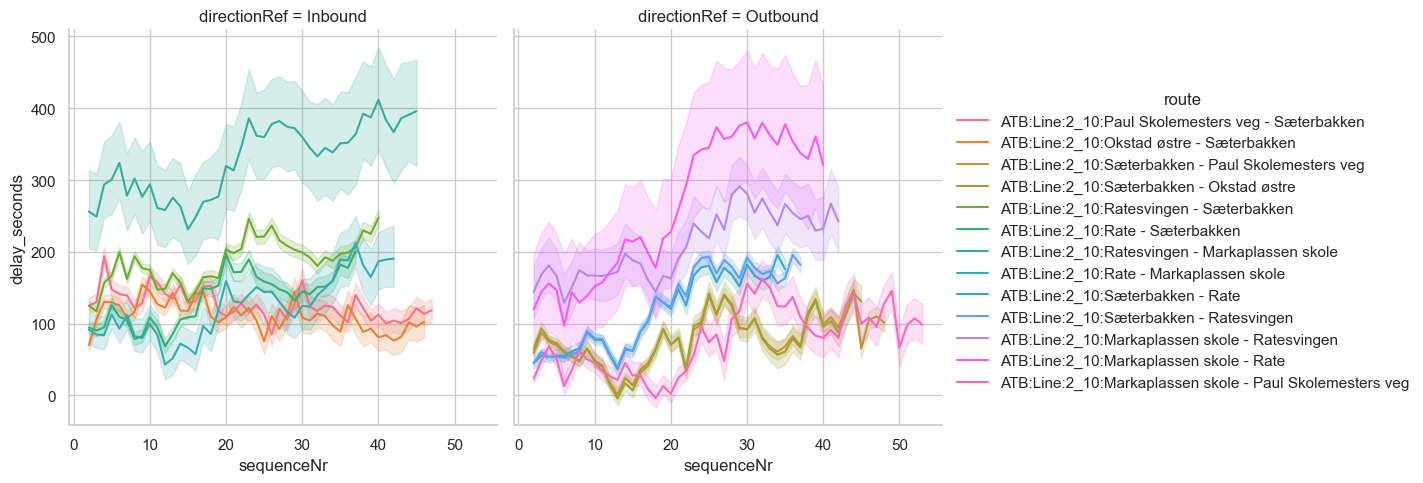

In [23]:
df = db.sql("""
select
  lineRef,
  extract(epoch from arrivalTime - aimedArrivalTime) as delay_seconds,
  directionRef,
  sequenceNr,
  lineRef || ':' || originName || ' - ' || destinationName as route
from arrivals
where abs(extract(epoch from arrivalTime - aimedArrivalTime)) < 1800
  and lineRef = 'ATB:Line:2_10'
  and operatingDate >= '2025-01-01'
""").df()

sns.relplot(
    df, x='sequenceNr', y='delay_seconds', col='directionRef', kind='line', hue='route'
);

Right, there's huge variability in how reliable they are. Some run like clockwork and some have many minutes of variability. It might be interesting to look into why. Maybe some depart during rush hour only, for example? We'll leave that question for now, and look at something else.

## Analyzing journey legs

One thing that I think might be very interesting would be to check the legs of each journey to check if we can identify physical locations that cause delays according to the schedule. This seems like something we should save to a table so that we won't have to couple each stop with the next stop more than once, because this is going to be a big join. We will need to pair up each recorded arrival time at a stop, with the arrival time at the previous stop, so it's going to be something like a 200 million by 200 million join. DuckDB will really get to test its mettle here.

Let's consider what we need:

1. The from-stop and to-stop. We'll get the names for convenience, and the ID so we can get geolocations later.
2. A time of day to associate with the data point so we can later check for things like rush hour or winter-time impact.
3. The planned time from arriving at the from-stop to arriving/departing at the to-stop.
4. The actual time from arriving at the from-stop to arriving/departing at the to-stop.
5. The `datedServiceJourneyId` so we can retrieve additional data by joining `arrivals` if we find out we need something else later.
6. We can probably skip `directionRef` as the from-stop/to-stop implicitly carries that information.

We will also filter out some data:

1. We will just drop journeys that have very high delays. We're interested in the typical, not the atypical.
2. Cancellations, extra stops, replacement transports, for the same reason.
3. The very first stop has no `arrivalTime` or `aimedArrivalTime` and the very last stop does not have `departureTime` or `aimedDepartureTime`. I want to check the time between arrival at the previous stop, and arrival at the next stop, including the stop itself. So we won't be able to use every row in the arrivals table.

**NB** Introducing new words. I need words both to describe how delayed a journey is overall, and how much delay it "collected" on a certain leg of a journey. I've settled for these terms:

- **delay** is the amount of seconds after planned arrival that a transport _actually_ arrived at a stop.
- **deviation** is the amount of seconds _longer_ than planned, it took on the journey from the previous stop, to this stop.
- **Edit**: For a future study, I would probably calculate **deviation** as _seconds longer than typical for the journey leg_, it seems more useful.

There's probably some more precise jargon for this in the public transit sector that I'm not aware of. I'll note for myself that I shouldn't drop these into casual conversation without clarifying what I mean first.

I'm expecting this to take a few minutes, since it'll need to visit many columns of almost all rows and do an expensive join, so I'll make sure to only run this if the table does not already exist.

In [24]:
exists = db.query("select exists(select 1 from information_schema.tables where table_name = 'legs')").fetchone()[0]

create = """
create table legs as select
  now.lineRef as lineRef,
  previous.stopPointName as previous_stop_name,
  previous.stopPointRef as previous_stop,
  now.stopPointName as stop_name,
  now.stopPointRef as stop,
  now.datedServiceJourneyId as datedServiceJourneyId,
  now.arrivalTime as time,
  now.aimedArrivalTime as planned_time,
  extract(epoch from now.aimedArrivalTime - previous.aimedArrivalTime) as planned_duration,
  extract(epoch from now.arrivalTime - previous.arrivalTime) as actual_duration,
  actual_duration - planned_duration as deviation,
  extract(epoch from time - planned_time) as delay
from arrivals previous join arrivals now on
  previous.datedServiceJourneyId = now.datedServiceJourneyId
  and previous.sequenceNr + 1 = now.sequenceNr
where
  abs(deviation) < 1800 and abs(delay) < 3600
  and not (now.journeyCancellation or now.stopCancellation or now.extraCall);
"""

if not exists:
    db.execute(create)

db.sql("select * from legs where time > '2025-01-01' limit 1").df().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,0
lineRef,ATB:Line:2_14
previous_stop_name,Gildheim
previous_stop,NSR:Quay:75658
stop_name,Leangen
stop,NSR:Quay:71363
datedServiceJourneyId,2025-01-01:ATB:ServiceJourney:14_2310101430651...
time,2025-01-01 12:21:13+01:00
planned_time,2025-01-01 12:20:00+01:00
planned_duration,60.0
actual_duration,134.0


Okay, that took 3 minutes and 10 seconds on my laptop -- not too bad. One of those rare occasions where I heard the fan spinning for a while. **Edit**: Testing this on my desktop, which has 12 cores and 64GB RAM, it's 2 minutes. The join spills to disk on both machines, hard to avoid for such a big join. I noticed it created an `entur.db.tmp` file in the same directory as the database. The biggest size I observed for it was 22GB (this is why I tried to run it on my desktop, I thought maybe it would fit in RAM. Unsurprisingly, it didn't.).

Subsequent queries towards this table will be fast, since we don't need to do the expensive join again.

Let's check how some of this data looks, to get our bearings. I discovered a nifty `select * exclude(col1, col2)` syntax that's very convenient for exploring the data:

In [25]:
%%sql
SELECT
  * exclude (previous_stop, stop, datedServiceJourneyId)
FROM
  legs
WHERE
  stop_name = 'Nidarosdomen'
  AND TIME > '2025-02-10'
LIMIT
  10;

Running query in 'duckdb'

lineRef,previous_stop_name,stop_name,time,planned_time,planned_duration,actual_duration,deviation,delay
ATB:Line:2_3,Kongens gate,Nidarosdomen,2025-02-12 15:19:25+01:00,2025-02-12 15:19:00+01:00,120.0,166.0,46.0,25.0
ATB:Line:2_3,Kongens gate,Nidarosdomen,2025-02-12 17:04:29+01:00,2025-02-12 17:05:00+01:00,120.0,119.0,-1.0,-31.0
ATB:Line:2_3,Kongens gate,Nidarosdomen,2025-02-12 10:01:20+01:00,2025-02-12 09:59:00+01:00,60.0,180.0,120.0,140.0
ATB:Line:2_10,Prinsens gate,Nidarosdomen,2025-02-12 15:49:08+01:00,2025-02-12 15:47:00+01:00,120.0,188.0,68.0,128.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 15:37:04+01:00,2025-02-12 15:34:00+01:00,60.0,94.0,34.0,184.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 06:40:00+01:00,2025-02-12 06:40:00+01:00,60.0,60.0,0.0,0.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 09:21:48+01:00,2025-02-12 09:20:00+01:00,60.0,79.0,19.0,108.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 13:32:19+01:00,2025-02-12 13:30:00+01:00,60.0,69.0,9.0,139.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 18:53:44+01:00,2025-02-12 18:50:00+01:00,60.0,86.0,26.0,224.0
ATB:Line:2_3,Studentersamfundet,Nidarosdomen,2025-02-12 05:50:04+01:00,2025-02-12 05:50:00+01:00,60.0,58.0,-2.0,4.0


In [26]:
%%sql
SELECT
  * exclude (previous_stop, stop, datedServiceJourneyId)
FROM
  legs
WHERE
  stop_name = 'Berkåk'
  AND TIME > '2025-02-10'
LIMIT
  10;

Running query in 'duckdb'

lineRef,previous_stop_name,stop_name,time,planned_time,planned_duration,actual_duration,deviation,delay
SJN:Line:F6,Oppdal,Berkåk,2025-02-10 22:12:07+01:00,2025-02-10 22:10:00+01:00,1560.0,1532.0,-28.0,127.0
SJN:Line:F6,Støren,Berkåk,2025-02-16 16:13:16+01:00,2025-02-16 16:07:00+01:00,1440.0,1565.0,125.0,376.0
SJN:Line:F6,Støren,Berkåk,2025-02-16 14:09:42+01:00,2025-02-16 14:04:00+01:00,1500.0,1729.0,229.0,342.0
SJN:Line:F6,Støren,Berkåk,2025-02-20 08:48:57+01:00,2025-02-20 08:47:00+01:00,1440.0,1651.0,211.0,117.0
SJN:Line:F6,Støren,Berkåk,2025-02-20 16:42:50+01:00,2025-02-20 16:43:00+01:00,1560.0,1881.0,321.0,-10.0
SJN:Line:F6,Støren,Berkåk,2025-02-20 14:21:48+01:00,2025-02-20 14:17:00+01:00,1620.0,1687.0,67.0,288.0
SJN:Line:F6,Oppdal,Berkåk,2025-02-15 13:53:59+01:00,2025-02-15 13:49:00+01:00,1560.0,1493.0,-67.0,299.0
SJN:Line:F6,Oppdal,Berkåk,2025-02-20 22:16:04+01:00,2025-02-20 22:13:00+01:00,1500.0,1514.0,14.0,184.0
SJN:Line:F6,Støren,Berkåk,2025-02-12 16:08:24+01:00,2025-02-12 16:07:00+01:00,1440.0,1581.0,141.0,84.0
SJN:Line:F6,Oppdal,Berkåk,2025-02-12 13:51:17+01:00,2025-02-12 13:49:00+01:00,1560.0,1571.0,11.0,137.0


Perfect, that looks exactly like what I'm after. In passing, I notice that the planned length is always in while minutes, which makes sense since these schedules are printed and physically glued to stop places. It would perhaps be unreasonable to expect second-level precision on planning them anyway. Let's check if there are any legs with a planned length of 0 seconds (which would happen if arrival at both stops is within the same minute):

In [27]:
%%sql
SELECT
  100 * (
    SELECT
      COUNT(*)
    FROM
      legs
    WHERE
      planned_duration = 0
  ) / (
    SELECT
      COUNT(*)
    FROM
      legs
  ) AS percent

Running query in 'duckdb'

percent
7.129239237773323


Okay, around 7% of the legs have an unreasonably tight schedule of being in two stops in the same minute. I would expect these legs to record deviations most of the time, since we've defined a deviation as "actual duration longer than planned duration", and we calculate "planned duration" to be 0 seconds.

In [28]:
%%sql

select mean(deviation), median(deviation), quantile_disc(deviation, .95) from legs where planned_duration = 0

Running query in 'duckdb'

mean(deviation),median(deviation),"quantile_disc(deviation, .95)"
38.77935172164669,33.0,79.0


The median deviation here is 33 seconds. This tells me that schedules only place two stops within the same minute if they're very close, close enough that the bus can get from one to the next in 33 seconds or less, half the time.

In [29]:
%%sql

select mean(deviation), median(deviation), quantile_disc(deviation, .95) from legs where planned_duration != 0

Running query in 'duckdb'

mean(deviation),median(deviation),"quantile_disc(deviation, .95)"
-0.30028851487047514,-1.0,65.0


The deviation seems typically quite low for both kinds of legs -- our scale is seconds, after all. The legs where the planned duration is 0 are probably quite short, in terms of physical distance.

It's interesting to me to note that the median is 1 second. This means that roughly half of the stop-to-stop legs take less than the time the schedule says they should, and half takes more.

We would expect this to look quite different from trains, which have further to travel between stops:

In [30]:
%%sql

select mean(deviation), median(deviation), quantile_disc(deviation, .95) from legs where lineRef not like 'ATB:%';


Running query in 'duckdb'

mean(deviation),median(deviation),"quantile_disc(deviation, .95)"
2.717605982308826,-2.0,116.0


It's interesting that the mean and median deviation is so close to 0. The schedules seem to be pretty good for estimating the time each individual leg of a journey.

An interesting thing we can easily do now is to check which legs that has the highest typical deviation:

In [31]:
%%sql
WITH
  by_stop AS (
    SELECT
      median (deviation) AS deviation,
      COUNT(*) AS travels,
      previous_stop_name,
      stop_name
    FROM
      legs
    GROUP BY
      previous_stop_name,
      stop_name
    HAVING
      COUNT(*) > 10
  )
SELECT
  *
FROM
  by_stop
ORDER BY
  deviation desc
LIMIT
  10

Running query in 'duckdb'

deviation,travels,previous_stop_name,stop_name
1677.0,65,Namdalseid skole,Bjørg
1526.0,24,Darbu,Gulskogen
1068.0,12,Meldal ruteb.st.,Hove i Meldal
951.5,474,Stortangen skole,Lindal
940.0,969,Sletta,Singstad
930.0,13,Jaren,Roa
883.0,480,Bergkorsen,Nesset
744.0,36,Kvislabakken skole,Vollan
738.0,1066,Tydal skole,Berggardsmyra
731.0,625,Campus Guldbergaunet,Nordsida


Lots of legs with very little traffic here, and long distances. I know that at least some of these stops are in rural areas.

Let's focus on the ones with lots of registrations. These are probably closer to cities.

In [32]:
%%sql
with by_stop as (
    select
      median(deviation) as deviation,
      quantile_disc(deviation, .95) as pct_95,
      count(*) as travels,
      previous_stop_name,
      stop_name
    from legs
    group by previous_stop_name, stop_name
    having count(*) > 10000
)
select * from by_stop order by deviation desc limit 10

Running query in 'duckdb'

deviation,pct_95,travels,previous_stop_name,stop_name
195.0,340.0,29823,Dronningens gt.,Einar Tambarskjelves gate
191.0,331.0,24167,Dronningens gate,Einar Tambarskjelves gate
138.0,291.0,49098,Dronningens gate,Olav Kyrres gate
125.0,169.0,14281,Hjelnesset,Kråknesset
106.0,132.0,18308,Berre,Fossli vegdele
105.0,176.0,48001,Jessheim,Nordby
102.0,238.0,11889,Oslo S,Holmlia
101.0,169.0,26463,Fosskrysset,Fossbakken
98.0,228.0,10812,Markaplassen skole,Vikåsen skole
89.0,185.0,16666,Nordsida,Rungstad


This is interesting stuff! I want to put this on a map visualization at some point...

A lot of these are stops that changed names, or no longer exist. For a map visualization, it would probably only be interesting with quite recent data, perhaps only the last year.

Let's take a look at only 2025 registrations.

In [33]:
%%sql
with by_stop as (
    select
      median(deviation) as deviation,
      quantile_disc(deviation, .95) as pct_95,
      count(*) as travels,
      previous_stop_name,
      stop_name
    from legs
    where time >= '2025-01-01'
    group by previous_stop_name, stop_name
    having count(*) > 5000
)
select * from by_stop order by deviation desc limit 10

Running query in 'duckdb'

deviation,pct_95,travels,previous_stop_name,stop_name
66.0,95.0,5117,Flatåsen senter,Kolstadhaugen
58.0,145.0,8818,Kongens gate,Nidarosdomen
52.0,217.0,17319,Oslo S,Nationaltheatret
48.0,152.0,16018,Lysaker,Skøyen
43.0,72.0,10663,Tonstadkrysset,Rostengrenda
42.0,125.0,34503,Prinsens gate,Nidarosdomen
42.0,97.0,6733,Skovgård,Askeladdvegen
39.0,120.0,5866,City Syd E6,Hårstadkrysset
38.0,199.0,8592,Oslo S,Lillestrøm
37.0,61.0,12160,Løvaasveien,Djupmyra


Now, I want to look into where _my_ buses get delayed (the legs where they have a positive deviation). I'll look at line 14 first, it's the only line that visits my closest stop, so I'll get the `datedServiceJourneyId` from there. I want to check whether some legs typically cause much more deviations than others.

In [34]:
%%sql

with my_bus as (
    select distinct datedServiceJourneyId from arrivals where stopPointName = 'Høyset'
), by_stop as (
    select
      median(deviation) as deviation,
      quantile_disc(deviation, .95) as pct_95,
      count(*) as travels,
      previous_stop_name,
      stop_name
    from legs join my_bus using(datedServiceJourneyId)
    group by previous_stop_name, stop_name
    having count(*) > 5000
)
select * from by_stop order by deviation desc limit 20

Running query in 'duckdb'

deviation,pct_95,travels,previous_stop_name,stop_name
45.0,85.0,67518,Berg studentby,Østre Berg 2
33.0,63.0,6410,Skovgård 1,Leangen
33.0,63.0,101298,Charlottenlund vgs,Konglevegen
32.0,59.0,121926,Voll studentby,Åsvang skole
32.0,68.0,61209,Travbanen,Skovgård 3
29.0,57.0,49912,Skovgård,Leangen
28.0,46.0,67730,Jakobslivegen Øvre,Jakobsli
28.0,74.0,59484,Leangen,Skovgård
27.0,45.0,59842,Jakobslivegen øvre,Jakobsli
26.0,49.0,127936,Charlottenlund kirke,Konglevegen


The median deviation is quite even. What I observe when traveling to and from work is that the roundabout between Lerkendal gård and Berg Studentby is heavily affected by rush traffic. It would be fun to try to visualize all buses that travel through it and check for rush hour traffic, focusing on the actual time taken. I want to visualize the confidence interval, which is expensive, so I'll limit this to only 2025 to make it fast.

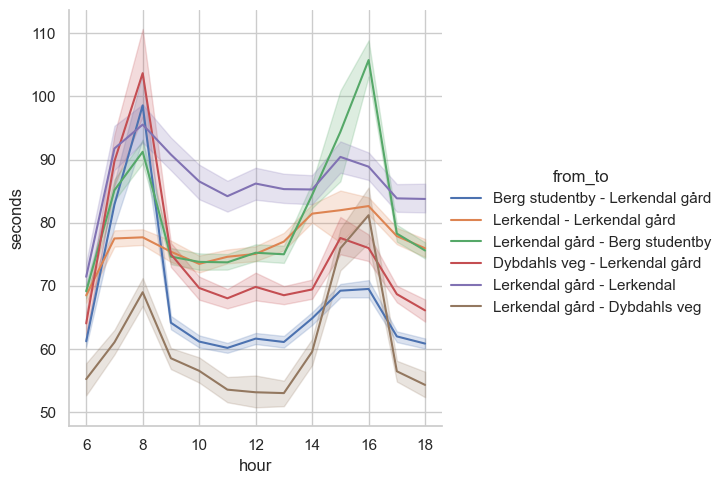

In [35]:
df = db.sql("""
select
  actual_duration as seconds,
  previous_stop_name || ' - ' || stop_name as from_to,
  extract(hour from time) as hour,
from legs
where
  (stop_name = 'Lerkendal gård' or previous_stop_name = 'Lerkendal gård')
  and time >= '2025-01-01' and hour between 6 and 18
""").df()

sns.relplot(
    df, x='hour', y='seconds', kind='line', hue='from_to'
);


That's fun, that closely matches what I had expected to see! It seems like rush hour makes most of these legs 30-40 seconds slower (those seconds _feel_ way slower when I'm in a hurry).

This makes me really want to get geolocation for stops, so I can plot this in a map and look for other hot-spots like this. Let's check how many unique previous stops and stop combinations we have, so we can get an idea of how much data an interactive visualization like that would need to collect.

In [36]:
%%sql
SELECT
  COUNT(*) AS combinations
FROM
  (
    SELECT DISTINCT
      previous_stop,
      stop
    FROM
      legs
  )

Running query in 'duckdb'

combinations
32839


I think perhaps that's too much. What if we include only 2025?

In [37]:
%%sql
SELECT
  COUNT(*) AS combinations
FROM
  (
    SELECT DISTINCT
      previous_stop,
      stop
    FROM
      legs
    WHERE
      TIME >= '2025-01-01'
  )

Running query in 'duckdb'

combinations
14734


That's still a lot of dots on a map. Let's look into whether some disappear if we only take the legs where we have over 100 registrations:

In [38]:
%%sql
SELECT
  COUNT(*) AS combinations
FROM
  (
    SELECT
      previous_stop,
      stop,
      COUNT(*)
    FROM
      legs
    WHERE
      TIME >= '2025-01-01'
    GROUP BY
      previous_stop,
      stop
    HAVING
      COUNT(*) > 100
  )

Running query in 'duckdb'

combinations
5413


That seems like it could be manageable. We might be looking at a few aggregations per hour for each of these, so we'd need to load perhaps half a million to a million data points into a browser. That should be easily manageable, especially if we can use DuckDB in the browser so we can load it from something like a parquet file or DuckDB file in object storage (S3 or GCS), which supports predicate pushdown. That would also let people play with this data on the [DuckDB Online Shell](https://shell.duckdb.org/), which would be very cool!

## Geolocating stop points

I would like to be able to place stop points in a map. And I would like to be able to estimate the distance between stop points. I'll try to get all the stop points from the [national stop registry](https://data.entur.no/domain/public-transport-data/product/national_stop_registry/urn:li:container:7fd60886cfa95c660d5c85ac0384eb9a). It is my hope that I can use the IDs of the real time data set to fetch these. Let's try just one, at first.

In [39]:
stop_point_table = "`ent-data-sharing-ext-prd.national_stop_registry.stop_places_all_versions`"

stop = db.sql("select stop from legs where stop_name = 'Nidarosdomen' limit 1").df().stop.iloc[0]
client.query(f"""
select
   id,
   version,
   name,
   location_longitude,
   location_latitude,
   validBetween
from {stop_point_table}
where id = '{stop}'
""").result().to_dataframe()

,id,version,name,location_longitude,location_latitude,validBetween


Ah, that's unfortunate -- no results. Let's check what the ID is for Nidarosdomen in this dataset and see if we can fix this:

In [40]:
client.query(f"""
select
   id,
   version,
   name,
   location_longitude,
   location_latitude,
   validBetween
from {stop_point_table}
where name = 'Nidarosdomen'
""").result().to_dataframe()

,id,version,name,location_longitude,location_latitude,validBetween
0,NSR:StopPlace:41609,6,Nidarosdomen,10.393397,63.426011,"{'toDate': 2021-02-02 13:01:48.999000+00:00, '..."
1,NSR:StopPlace:41609,8,Nidarosdomen,10.393437,63.426015,"{'toDate': None, 'fromDate': 2025-01-23 10:29:..."
2,NSR:StopPlace:41609,7,Nidarosdomen,10.393437,63.426015,"{'toDate': 2025-01-23 10:29:32.843000+00:00, '..."


In [41]:
stop

'NSR:Quay:71174'

Maybe what I've been calling a "stop" is actually a quay, I notice that there's another table in BigQuery. Let's check that:

In [42]:
quays_table = "`ent-data-sharing-ext-prd.national_stop_registry.quays_all_versions`"

client.query(f"""
select
   id,
   version,
   name,
   location_longitude,
   location_latitude
from {quays_table}
where id = '{stop}'
""").result().to_dataframe()

,id,version,name,location_longitude,location_latitude
0,NSR:Quay:71174,1,None,10.393300,63.425877
1,NSR:Quay:71174,2,None,10.393300,63.425877
2,NSR:Quay:71174,3,None,10.393300,63.425877
3,NSR:Quay:71174,4,None,10.393300,63.425877
4,NSR:Quay:71174,5,None,10.393300,63.425877
5,NSR:Quay:71174,6,None,10.393300,63.425877
6,NSR:Quay:71174,7,None,10.393372,63.425815
7,NSR:Quay:71174,8,None,10.393372,63.425815


Ah, seems like this is what we want, then. To simplify things, we'll accept the chance of some historical inaccuracy and use only the latest version. There's a table for that too. Let's download it. Like before, we'll run this query only if we don't already have the data, unlike before, we don't have to do any paging, this table is tiny.

In [43]:
quays_table = "`ent-data-sharing-ext-prd.national_stop_registry.quays_last_version`"
exists = db.query("select exists(select 1 from information_schema.tables where table_name = 'quays')").fetchone()[0]

if not exists:
    quays = client.query(f"""
    select
       id,
       location_longitude,
       location_latitude
    from {quays_table}""").result().to_arrow()
    db.execute("create table quays as select * from quays")

db.sql("select * from quays limit 5")

┌────────────────┬────────────────────┬───────────────────┐
│       id       │ location_longitude │ location_latitude │
│    varchar     │       double       │      double       │
├────────────────┼────────────────────┼───────────────────┤
│ NSR:Quay:1612  │          11.379885 │          59.66847 │
│ NSR:Quay:1635  │           11.31901 │         59.622066 │
│ NSR:Quay:1692  │          11.318755 │          59.71065 │
│ NSR:Quay:17650 │          11.006233 │          60.73615 │
│ NSR:Quay:1733  │          11.089622 │          59.27479 │
└────────────────┴────────────────────┴───────────────────┘

Let's try to check if we miss any locations found in the real time data set.

In [44]:
%%sql
WITH
  stops AS (
    SELECT DISTINCT
      stopPointRef
    FROM
      arrivals
  )
SELECT
  COUNT(*)
FROM
  stops
  LEFT JOIN quays ON stops.stopPointRef = quays.id
WHERE
  quays.id IS NULL

Running query in 'duckdb'

count_star()
8944


Ouch, that's unfortunate. Let's take a look at a sample. Maybe we need the other table after all...

In [45]:
%%sql
WITH
  stops AS (
    SELECT
      stopPointRef,
      stopPointName,
      MAX(operatingDate) AS last_seen
    FROM
      arrivals
    GROUP BY ALL
  )
SELECT
  stops.stopPointRef,
  stops.stopPointName,
  stops.last_seen
FROM
  stops
  LEFT JOIN quays ON stops.stopPointRef = quays.id
WHERE
  quays.id IS NULL
ORDER BY
  stops.last_seen desc
LIMIT
  10

Running query in 'duckdb'

stopPointRef,stopPointName,last_seen
STC,Stockholm C,2025-02-20
LE,Luleå,2025-02-20
KRH,Kristinehamn,2025-02-16
ROM,Rombak,2025-02-11
CGG,Charlottenberg Grense,2025-02-10
BJF,Bjørnfjell,2025-02-09
SKØ,Skøyen,2025-01-23
KAT,Katterat,2025-01-13
BFG,Bjørnefjell Grense,2024-12-31
KC,Kiruna C,2024-12-25


It looks like maybe this has to do with recency, or trains. There are very few places we've seen used in Trondheim the past few months that we can't geolocate, plenty good enough for my purposes at least. Let's check how much of our data the past year that is impacted:

In [46]:
%%sql

select 100 * mean((quays.id is null) :: double) as pct_missing
from arrivals left join quays on arrivals.stopPointRef = quays.id
where operatingDate >= '2024-01-01'

Running query in 'duckdb'

pct_missing
0.019989712869054585


We're unable to geolocate around 0.02% of the data set we're looking at here, of recordings after 2024-01-01. I did a little playing around with the stop places table, looking for a few of these, and I was unable to find them. For me, it's acceptable to discard 0.02% of our data to be able to place the rest of it in a map.

What would be fun now, would be to estimate the distances between the stop points in our legs table. Ideally, we'd use something like driving distances, but since we also have train and possibly ferry stops, that might not be easy. I will settle for estimating a lower bound on the distance, using [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) to calculate an approximate distance as the bird flies. This will also let me do an upper bound estimate for the average speed on a leg, which might be fun to look at.

## Estimating journey leg distance

I find it easier to formulate the haversine distance formula in Python, so I'll pull up all the unique pairs of stops and their location into pandas, then add a distance estimate column and write it back to DuckDB. We're only looking at calculating 30k rows or so, so it should be superfast anyway.

In [47]:
df = db.sql("""
with unique_legs as (
   select distinct previous_stop, stop from legs
)
select
    ul.previous_stop,
    prev_quay.location_longitude as prev_lon,
    prev_quay.location_latitude as prev_lat,
    ul.stop,
    cur_quay.location_longitude as now_lon,
    cur_quay.location_latitude as now_lat,
from unique_legs ul
    join quays prev_quay on ul.previous_stop = prev_quay.id
    join quays cur_quay on ul.stop = cur_quay.id
""").df()

# This is hopefully a correct haversine distance calculation, giving the distance
# between two points on the surface of a perfect sphere with Earths radius. I think this
# would look even more gnarly in SQL. We're using fast vectorized numpy operations here,
# so this is completely dominated by finding the distinct previous/next stops anyway
earth_radius_km = 6378.0
lon1 = np.radians(df.prev_lon)
lat1 = np.radians(df.prev_lat)
lat2 = np.radians(df.now_lat)
lon2 = np.radians(df.now_lon)

delta_lon = lon2 - lon1
delta_lat = lat2 - lat1

hav_a = np.sin(delta_lat / 2) ** 2
hav_b = np.sin(delta_lon / 2) ** 2
distance_km = earth_radius_km * 2 * np.arcsin(
    np.sqrt(hav_a + np.cos(lat1) * np.cos(lat2) * hav_b)
)
leg_distances = df.assign(
    air_distance_km=distance_km
)

# Record this to a table for convenient joins later on
db.execute(
    "create or replace table distances as select * from leg_distances"
)

leg_distances.air_distance_km.describe()

count    20682.000000
mean         8.459324
std         26.875725
min          0.000000
25%          0.634709
50%          1.377583
75%          4.152770
max        383.490228
Name: air_distance_km, dtype: float64

Almost all the legs have a very short air distance. This is unsurprising. Let's check how many that have a 0 distance -- that should only happen if we geolocated two stops to the same area, which is hopefully only possible if a leg had a previous stop and current stop that were the same ID (`stopPointRef`).

In [48]:
%%sql
SELECT
  *
FROM
  distances
WHERE
  air_distance_km = 0
  AND previous_stop != stop

Running query in 'duckdb'

previous_stop,prev_lon,prev_lat,stop,now_lon,now_lat,air_distance_km


Okay, so all the 0 distances we calculated are legs were the vehicle didn't actually move anywhere. How many of our legs are like that?

In [49]:
%%sql
SELECT
  COUNT(*) AS COUNT
FROM
  legs
WHERE
  previous_stop = stop

Running query in 'duckdb'

COUNT
1320


Thankfully very few, so these aren't _actually_ a problem, we'll just discard these. I want to materialize the raw data for our legs visualization now. I'm going to write this to a new table. Expecting this to take maybe a few minutes.

In [50]:
%%sql
CREATE
OR replace TABLE legs_distance AS
SELECT
  *
FROM
  legs
  JOIN distances USING (previous_stop, stop)
WHERE
  previous_stop != stop
  AND TIME >= '2024-01-01'

Running query in 'duckdb'

Count
48285701


That was actually just 10 odd seconds, I am impressed. We are down to about 50 million data points now.

Let's take a look at the fastest legs we recorded, just for fun. I certainly hope to see the trains near the top

In [51]:
db.sql("""
with speed as (
    select *, air_distance_km / (actual_duration / 3600) as speed_km_h_upper_bound
    from legs_distance
)
select
    previous_stop_name, stop_name, time, actual_duration as duration_seconds, speed_km_h_upper_bound, air_distance_km
from speed
where actual_duration > 0
order by speed_km_h_upper_bound desc
limit 30
""").df()

,previous_stop_name,stop_name,time,duration_seconds,speed_km_h_upper_bound,air_distance_km
0,Lillestrøm,Oslo S,2024-07-05 05:27:01+02:00,1.0,60455.801465,16.793278
1,Asker,Drammen,2025-01-23 10:29:00+01:00,2.0,29705.684967,16.503158
2,Asker,Drammen,2024-12-18 17:09:00+01:00,3.0,19803.789978,16.503158
3,Asker,Drammen,2024-11-12 10:08:00+01:00,3.0,19803.789978,16.503158
4,Asker,Drammen,2024-11-25 09:08:00+01:00,4.0,14852.842484,16.503158
5,Asker,Drammen,2025-01-15 13:09:00+01:00,4.0,14852.842484,16.503158
6,Olsøya,Kråkmo vegdele,2025-01-17 18:21:01+01:00,1.0,13167.817567,3.657727
7,Svingen,Sørumsand,2024-12-23 23:30:00+01:00,2.0,13029.788763,7.238772
8,Nordbø,Bruholtveien,2024-10-15 09:11:29+02:00,1.0,12790.283790,3.552857
9,Asker,Drammen,2024-10-10 09:28:00+02:00,5.0,11882.273987,16.503158


Ah, looks like we found a data quality issue. Some of these bullet-buses will likely skew the map visualization, so we note to ourselves that we should fix this.

I think we can reasonably expect all vehicles that traveled faster than 250km/h to be errors in the data. Let's check how many there are:

In [52]:
%%sql
select 100 * mean((air_distance_km / (actual_duration / 3600) > 250) :: double) as bullet_bus_pct
from legs_distance


Running query in 'duckdb'

bullet_bus_pct
0.15764501378990023


Ah, this problem impacts almost no data, less than .2%. We'll just remove those.


## Outline of data cleaning job

I feel like I'm getting familiar enough with this data now, that I can write a job that produces a reasonably high quality dataset for a map visualization. I'm noting to myself the steps I've done to get here:

1. Get raw data for quays and realtime data
2. Do the "big join" on the real time data to pair up previous and current stop
3. Calculate the distance between each unique pair of previous and current stop
4. Join the distance into the previous and next stops, dropping data we have no geolocation for
5. Drop all legs with unrealistically high speed
6. **Edit**: Later found some legs with negative actual_duration (approx 0.003% of data), need to drop these too because of dangerous timetravel paradoxes
7. Produce the aggregations I want to expose for a few different time periods and period lengths to enable an interactive dashboard

I'm going to make a program that does all of this later and produces some nice and small files that I can share. For now, I will manually drop all the bullet buses from further queries. To make that convenient, I'll add the speed calculation to the `legs_distance` table.

In [53]:
try:
    # This isn't very nice, but there's no `add or replace column` or `add column if not exists`
    # and generated/computed columns appear to not be supported yet.
    # I guess we could have easily layered a view on top of legs_distance instead.
    db.execute("alter table legs_distance add column speed_kmh_upper_bound double")
    db.execute("update legs_distance set speed_kmh_upper_bound = (air_distance_km / (actual_duration / 3600))")
except duckdb.CatalogException as _already_exists:
    pass

## Data sets to produce

If I'm going to deploy this somewhere, I want it to be a light process, or maybe just static files. That means I need to figure out which queries I want to host the result of, and visualize, up front.

I think year-month and hour of day is going to be a component of all the data that I want to show. Perhaps I'd like to offer an interactive slider for both of those.

A lot of the data I want to show is associated with a stop, and a previous stop. I think I'd like people to be able to visualize a stop, and optionally break it down into where the traffic arrived from. I will need to find out what to aggregate on a stop. The variables I'd like to visualize the distribution of, are `delay` and `deviation` and `actual_duration`.

For a map, for example, you may want to use the associate the radius of a circle, or the color of a circle with one of those. Then, hovering, or clicking the circle could show more information, both about the stop, the previous stop, and the distribution of variables. Let's check the values for these three variables. I think these are good aggregations to produce:

- count
- min
- max
- percentiles (10%, 25%, 50%, 75%, 90%)
- mean
- standard deviance

I'm creating `map_lat` and `map_lon` columns, with coordinates that are _near_ `previous_stop`, but in the direction of `stop`. Ideally I can plot these in a map without too many intersections and overlaps.

For plotting a line chart, we could use the 25% and the 75% percentile or the 10% and 90% as a shaded region, and show the mean or median. That would give people a pretty good idea of what the underlying data looks like, without having to send huge amounts of individual data points.

Let's try the "most exploded" version first, and see if we can get something useful. I'll write a function for this that string-interpolates the column name, so I don't have to do it many times. I'll use a [struct](https://duckdb.org/docs/sql/data_types/struct.html) for this so it's easy to change which variable we're looking at later. I'm going to be grouping on the stop _names_, not their IDs. I discovered that some IDs have the same name and are placed in the same location, so it would make a map visualization difficult to make. This probably means I'm introducing some error here, but I'm okay with that for a first pass at visualizing it in a map.

In [54]:
def aggregations(col: str) -> str:
    return f"""
    {{
     'min': min({col}),
     'max': max({col}),
     'percentiles': quantile_disc({col}, [.1, .25, .5, .75, .9]),
     'median': median({col}),
     'mean': round(mean({col})),
     'stddev': round(stddev({col}))
    }} as {col}_stats
"""

db.sql(f"""
create or replace table leg_stats as
select
    stop_name as stop,
    previous_stop_name as previous_stop,
    extract(year from time) as year,
    extract(month from time) as month,
    extract(hour from time) as hour,
    count(*) as count,
    round(mean(air_distance_km), 2) as air_distance_km,
    median(planned_duration) as planned_duration,
    first(now_lon) as stop_lon,
    first(now_lat) as stop_lat,
    first(prev_lon) as prev_lon,
    first(prev_lat) as prev_lat,
    first(now_lon) * .01 + first(prev_lon) * .99 as map_lon,
    first(now_lat) * .01 + first(prev_lat) * .99 as map_lat,
    {aggregations('actual_duration')},
    {aggregations('delay')},
    {aggregations('deviation')}
from legs_distance
where
  actual_duration > 0 and speed_kmh_upper_bound < 250
group by stop_name, previous_stop_name, year, month, hour
having count(*) >= 28 -- require at least daily data
""")

db.sql("select * from leg_stats where stop = 'Skøyen' limit 1").df().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,0
stop,Skøyen
previous_stop,Lysaker
year,2024
month,10
hour,13
count,533
air_distance_km,2.52
planned_duration,180.0
stop_lon,10.67863
stop_lat,59.922268


Let's also do one that isn't broken down by the `previous_stop`, but just aggregates all the source journeys to one quay. It doesn't really make sense to include the `planned_duration`, `actual_duration_stats` columns or the `air_distance_km` in this one.

In [55]:
db.sql(f"""
create or replace table stop_stats as
select
    stop_name as stop,
    extract(year from time) as year,
    extract(month from time) as month,
    extract(hour from time) as hour,
    count(*) as count,
    first(now_lon) as map_lon,
    first(now_lat) as map_lat,
    {aggregations('delay')},
    {aggregations('deviation')}
from legs_distance
where
  actual_duration > 0 and speed_kmh_upper_bound < 250
group by stop_name, year, month, hour
having count(*) >= 28 -- require at least daily data
""")

db.sql("select * from stop_stats where stop = 'Hesthagen' and hour = 7 limit 1").df().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,0
stop,Hesthagen
year,2024
month,11
hour,7
count,2517
map_lon,10.3972
map_lat,63.416799
delay_stats,"{'min': -122.0, 'max': 1788.0, 'percentiles': ..."
deviation_stats,"{'min': -86.0, 'max': 228.0, 'percentiles': [-..."


I'm going to export these into small files that I can easily share. It would also let me make a tiny dashboard app where I could just package up these files into the docker image, since they'll be small.

In [56]:
%sql copy (select * from stop_stats order by stop, year, month, hour, stop) to 'stop_stats.parquet';
%sql copy (select * from leg_stats order by previous_stop, stop, year, month, hour) to 'leg_stats.parquet';
!du -hs *_stats.parquet

Running query in 'duckdb'

Running query in 'duckdb'

 27M	leg_stats.parquet
 15M	stop_stats.parquet


I can easily bake this into a docker image, or put them on some cloud storage, or even check them in to git lfs.

## Where/when are the biggest rush hour impacts?

This is a question I kind of want to answer, but I'm not entirely sure how. My best idea right now is to rank by the ratio between `actual_duration` of an hour slot divided by `actual_duration` of the whole day. Naturally this requires `actual_duration > 0`, but we'll filter for `actual_duration >= 60` to only check out legs with some actual trip length. We'll need to aggregate. For the monthly aggregate, we'll use `median`, what's typical for the monthly duration of the leg. For the hourly aggregate, we'll use the `75%` percentile, to make it reflect the worst days of the month. There's nothing scientific about this, I just think it'll help me identify interesting journey legs to study.

To avoid heavy impact by outliers, we should also require quite a few registrations here. Let's give it a go.

In [57]:
%%sql

with by_hour as (
-- I recently learned that you can put the from first in DuckDB
-- That is patently amazing
    from legs_distance
    select
        quantile_disc(actual_duration, .75) as actual_duration_hour,
        previous_stop_name,
        stop_name,
        extract(year from time) as year,
        extract(month from time) as month,
        extract(hour from time) as hour
    where actual_duration > 0 and speed_kmh_upper_bound < 250
    group by all
    having count(*) >= 200
), by_month as (
    from legs_distance
    select
        median(actual_duration) as actual_duration_month,
        previous_stop_name,
        stop_name,
        extract(year from time) as year,
        extract(month from time) as month
    where actual_duration > 0 and speed_kmh_upper_bound < 250
    group by all
)
select
    round(actual_duration_hour / actual_duration_month, 2) as rush_factor,
    actual_duration_hour,
    actual_duration_month,
    previous_stop_name,
    stop_name,
    year,
    month,
    by_hour.hour,
    ls.deviation_stats
from by_hour
    join by_month using(previous_stop_name, stop_name, year, month)
    join leg_stats ls on
      (previous_stop_name, stop_name, year, month, by_hour.hour) = (ls.previous_stop, ls.stop, ls.year, ls.month, ls.hour)
where actual_duration_month >= 60
order by rush_factor desc;


Running query in 'duckdb'

rush_factor,actual_duration_hour,actual_duration_month,previous_stop_name,stop_name,year,month,hour,deviation_stats
7.04,542.0,77.0,Dalsaunevegen,Nidarvoll skole,2024,5,8,"{'min': -62.0, 'max': 1018.0, 'percentiles': [-28.0, 3.0, 99.0, 432.0, 689.0], 'median': 106.5, 'mean': 233.0, 'stddev': 280.0}"
4.47,496.0,111.0,St. Olavs hospital øst,Studentersamfundet,2024,11,15,"{'min': -88.0, 'max': 1009.0, 'percentiles': [-7.0, 55.0, 182.0, 381.0, 551.0], 'median': 182.0, 'mean': 235.0, 'stddev': 221.0}"
4.43,478.0,108.0,St. Olavs hospital øst,Studentersamfundet,2024,12,15,"{'min': -86.0, 'max': 817.0, 'percentiles': [-27.0, 0.0, 162.0, 361.0, 527.0], 'median': 162.0, 'mean': 206.0, 'stddev': 216.0}"
4.39,483.0,110.0,St. Olavs Hospital øst,Studentersamfundet,2024,8,15,"{'min': -87.0, 'max': 920.0, 'percentiles': [-23.0, 31.0, 167.0, 351.0, 483.0], 'median': 167.5, 'mean': 208.0, 'stddev': 207.0}"
3.87,430.0,111.0,St. Olavs hospital øst,Studentersamfundet,2024,10,15,"{'min': -96.0, 'max': 930.0, 'percentiles': [-21.0, 23.0, 157.0, 310.0, 468.0], 'median': 157.0, 'mean': 191.0, 'stddev': 197.0}"
3.67,411.0,112.0,St. Olavs Hospital øst,Studentersamfundet,2024,9,15,"{'min': -100.0, 'max': 929.0, 'percentiles': [-20.0, 72.0, 185.0, 295.0, 393.0], 'median': 185.0, 'mean': 191.0, 'stddev': 159.0}"
3.49,373.0,107.0,St. Olavs hospital øst,Studentersamfundet,2025,2,15,"{'min': -79.0, 'max': 981.0, 'percentiles': [-31.0, 3.0, 101.0, 252.0, 361.0], 'median': 101.0, 'mean': 153.0, 'stddev': 190.0}"
3.38,379.0,112.0,St. Olavs hospital øst,Studentersamfundet,2025,1,15,"{'min': -93.0, 'max': 1215.0, 'percentiles': [-23.0, 24.0, 109.0, 260.0, 428.0], 'median': 109.0, 'mean': 172.0, 'stddev': 210.0}"
2.59,202.0,78.0,Dalsaunevegen,Nidarvoll skole,2024,2,8,"{'min': -65.0, 'max': 874.0, 'percentiles': [-37.0, -19.0, 8.0, 131.0, 398.0], 'median': 8.0, 'mean': 90.0, 'stddev': 179.0}"
2.55,199.0,78.0,Dalsaunevegen,Nidarvoll skole,2024,4,8,"{'min': -65.0, 'max': 638.0, 'percentiles': [-38.0, -24.0, 14.0, 93.0, 276.0], 'median': 15.5, 'mean': 69.0, 'stddev': 139.0}"


I think this looks like a promising way to identify journey legs that have trouble in rush hour, as evident by the fact that all the time slots we identified are during rush hour. Also, I am in this data. Udduvoll bru øst to Klettkrysset was my morning commute for many years.

## Summary & where to next

I'm concluding this notebook now, it's already way too long and I really want to go over and make a map dashboard. I've been working many evening hours on this one already.

I learned so much! I only wish I realized I could write the `from` first in DuckDB about 1000 lines of SQL ago.

Here's a list of things I already know I want to do:

- Build a plotly dash or streamlit dashboard to create an interactive visualization experience that uses these parquet stat files and deploy it somewhere.
- Share the data files in a way that makes it convenient to query them with DuckDB from the browser (wasm).
- Share the repository (just make it public, really).
- Make a short script to page through the BQ dataset and produce a hive partitioned parquet or DuckDB file for local study, parameterized by `dataSource` and `operatingDate`.

Notes on the Entur dataset:

- The data quality seems quite good. We did identify some issues, we removed remarkably little data. Well done, public transportation sector! Getting good quality data out of real world physical processes is _hard_.
- I wish the original table had a "back-link" and "front-link" with information about the previous and next stop (arrival times and IDs).
- This is very exciting data to work with! I had to stop myself from digging further into this already.

Notes on DuckDB:

- It has some fantastic convenience functions. For exploratory data analysis, I really like `GROUP BY ALL` and `SELECT * EXCLUDE(...)`.
- I can put the `FROM` first! Finally!
- It is very, very fast. I've been doing analysis on data larger than RAM with a comfortable and short feedback loop. This whole notebook takes 4-5 minutes to run, once the Big Query data has been downloaded. For my hobby projects, DuckDB is going to replace spark/pyspark, I will no longer need it. For bigger things, I might seriously consider just getting a bigger machine.
- The integration with the Python ecosystem is super nice.
- The data files do get quite big, bigger than parquet files. The current one is about 21GB now. I can live with that.
- I had out of memory crashes when trying to use `approx_quantile`, but they went away when changing to `quantile_disc`. This was the only operational thing I encountered that took me more than a few seconds to figure out, everything else has been very smooth. It turns out that approximate functions may not always obey the [memory limit](https://duckdb.org/docs/configuration/pragmas.html#memory-limit).

Here's a list of things I _might_ do:

- Write a neat and tidy program that does all the steps from the data cleaning and aggregations we've done.
- Make it able to get new data/partitions after the current date.
- Combine this data set with weather data.
- Try to identify the actual driving distance between stops, instead of using air distance.
- Set up a data pipeline of some sort that publishes the raw data as hive partitioned parquet files in object storage (GCS, S3, Azure Data Lake Gen2) so people can use this without signing up for Google Cloud.
- Set up a data pipeline of some sort that keeps these aggregated stats up to date.

Right away, I will: Clear the output of all the notebook cells, drop all my local files and run the entire notebook from top to bottom to make sure it all works, before sharing anything with someone else. Then I will commit it to git, with all the output.

## Thanks!

If you actually read this entire notebook, color me impressed. There's about 7000-8000 words of prose & code here, if you made it all the way here, you're amazing! Thanks for reading.